# Simulation of a positron-induced Muon Source

Desciption
In this experiment we shoot high energy positrons on a target, aiming at the production of muons by means of the process 
$e^{+} + e^{−} \rightarrow \mu^{+} + \mu^{-}$.
Assume we have placed a 2 meter long, 1.7 Tesla dipole magnet after the target. A number of tracking detectors can be placed before the target, after the target before the magnet and after the magnet.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import poisson
import scipy.odr as spo
import time
from IPython.display import Image

from joblib import Parallel, delayed
import multiprocessing

## Data

The dataset has 4 column groups:
1. columns 1,2,3    -> scattering positions
2. columns 4,5,6    -> muons tri-momentum components (in the laboratory frame)
3. columns 7,8,9    -> antimuons tri-momentum components (in the laboratory frame)
4. columns 10,11,12 -> positrons tri-momentum components (in the laboratory frame)

In [ ]:
df=pd.read_csv("dataset.txt", sep=" ", index_col=False)

#Removing unphysical events with just zeros by asking the momenta of the positron to be bigger than 1 GeV
df=df[df.iloc[:,11]>0] 

df

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.002064,-0.006667,0.024110,0.013418,0.010555,26.1718,-0.013418,-0.010555,19.6198,0,0,45.7916
999996,-0.001824,-0.001494,0.026105,0.003372,0.019434,25.1396,-0.003372,-0.019434,20.5562,0,0,45.6958
999997,0.002128,-0.000650,0.028801,0.009716,0.008148,21.7877,-0.009716,-0.008148,22.5688,0,0,44.3564
999998,-0.000129,-0.003546,0.014003,-0.017934,0.020388,19.8603,0.017934,-0.020388,28.1794,0,0,48.0397


In [ ]:
mu_mass = 105.65/(10**3)
e_mass = 0.511/(10**3)

c = 299792458

NEvents=df.shape[0]

X=df["x_scattering"]
Y=df["y_scattering"]
Z=df["z_scattering"]

px_e=df["px_positron"]
py_e=df["py_positron"]
pz_e=df["pz_positron"]

Px_mu1=df["px_mu1"]
Py_mu1=df["py_mu1"]
Pz_mu1=df["pz_mu1"]

Px_mu2=df["px_mu2"]
Py_mu2=df["py_mu2"]
Pz_mu2=df["pz_mu2"]

col = ['z[m]', 'x_center[m]', 'y_center[m]', 'x_length[m]', 'y_length[m]']
detector = pd.DataFrame(data=np.zeros((12,5)), columns=col)

#initialize detector positions and lengths
detector['z[m]'] = [-0.31, -0.16, -0.01, 5.03, 6.03, 7.03, 12.43, 13.43, 14.43, 12.43, 13.43, 14.43]

## Experiment dimensions

### Before the target - positrons

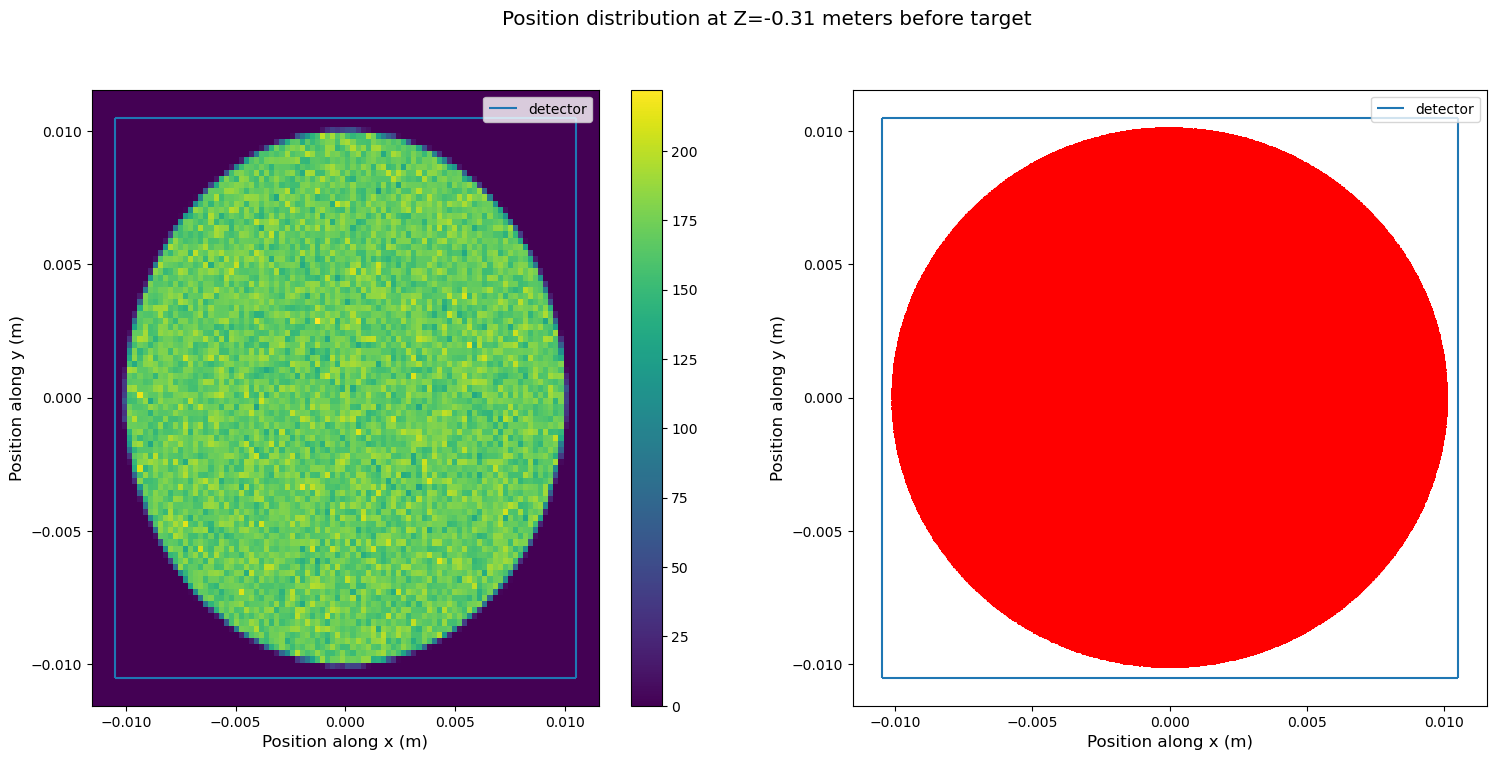

In order to contain the beam, we can use a detector with a x side of 0.021 m
In order to contain the beam, we can use a detector with a y side of 0.021 m


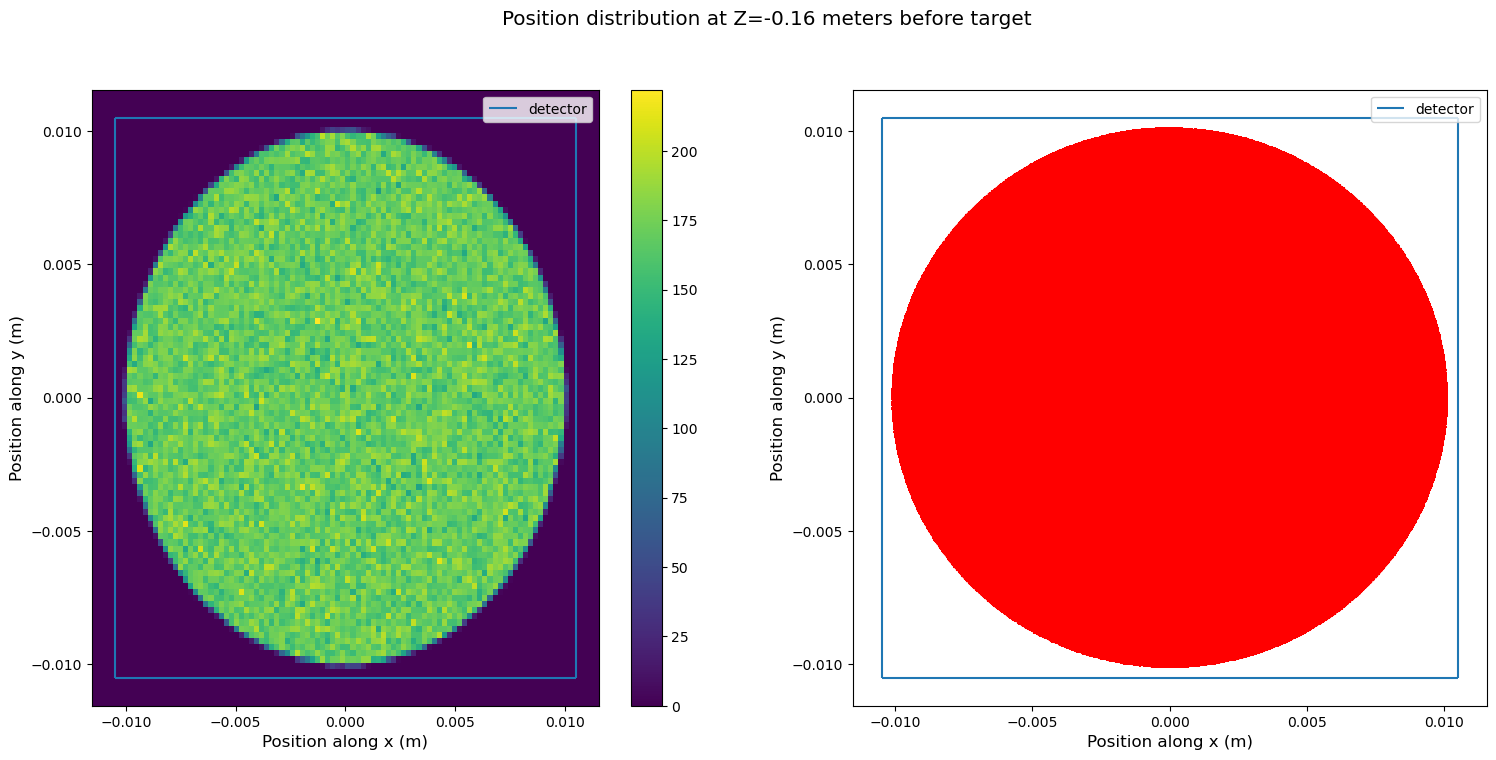

In order to contain the beam, we can use a detector with a x side of 0.021 m
In order to contain the beam, we can use a detector with a y side of 0.021 m


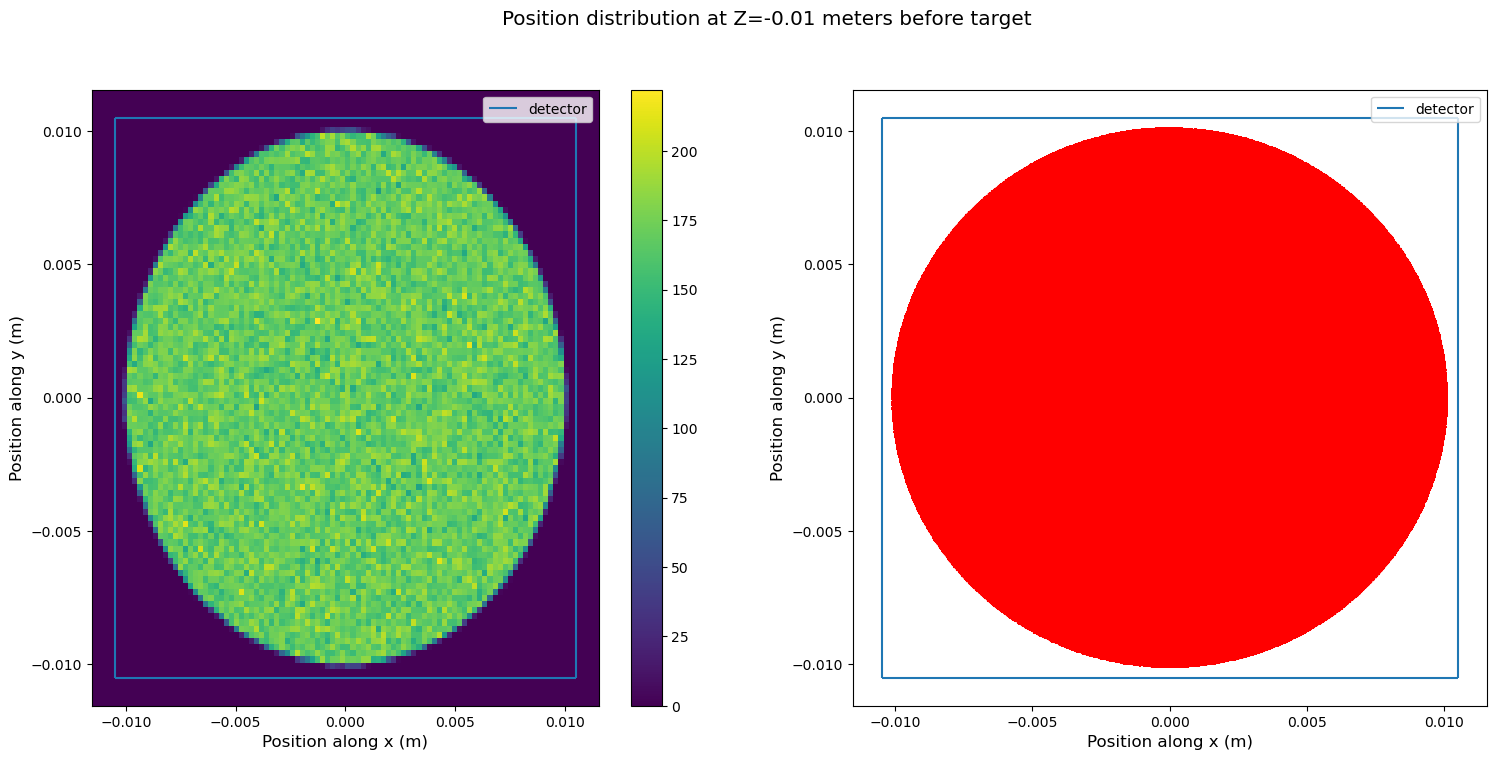

In order to contain the beam, we can use a detector with a x side of 0.021 m
In order to contain the beam, we can use a detector with a y side of 0.021 m


In [ ]:
Position_e_p = pd.DataFrame()

for i in range(3):
    Z_det = detector['z[m]'][i]
    t=(Z_det-Z)/(pz_e/mu_mass*c) 
    x=X+(px_e)*t  
    y=Y+(py_e/mu_mass*c)*t
    
    center_x = np.mean(x)
    center_y = np.mean(y)
    l_x = 2*np.max(np.abs( x - center_x )*1.05)
    l_y = 2*np.max(np.abs( y - center_y )*1.05)
    
  # We suppose that our precision in fixing the center of the detectors is 10^(-4) meters
    detector['x_center[m]'][i] = np.round(center_x, 4)
    detector['y_center[m]'][i] = np.round(center_y, 4)
    detector['x_length[m]'][i] = np.round(l_x, 3)
    detector['y_length[m]'][i] = np.round(l_y, 3)
    
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,8))
    fig.suptitle('Position distribution at Z={} meters before target'.format(Z_det),fontsize='x-large')
    
    #plot the histogram with the particle distribution
    h2d = ax1.hist2d(x, y, bins=(100, 100), range=[[center_x-(l_x/2)*1.1 , center_x+(l_x/2)*1.1 ],
                                                   [center_y-(l_y/2)*1.1 , center_y+(l_y/2)*1.1]])
    ax1.set_xlabel("Position along x (m)",fontsize='large')
    ax1.set_ylabel("Position along y (m)",fontsize='large')
    ax1.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, label='detector')
    ax1.vlines(center_x+l_x/2, center_y-l_y/2, center_y+l_y/2)
    ax1.hlines(center_y-l_y/2, center_x-l_x/2, center_x+l_x/2)
    ax1.hlines(center_y+l_y/2, center_x-l_x/2, center_x+l_x/2)
    ax1.legend()
    fig.colorbar(h2d[3], ax=ax1)
    
    #distribution with the detector shape
    ax2.scatter(x,y,color='red', marker='+')
    
    #detector figure
    ax2.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, label='detector')
    ax2.vlines(center_x+l_x/2, center_y-l_y/2, center_y+l_y/2)
    ax2.hlines(center_y-l_y/2, center_x-l_x/2, center_x+l_x/2)
    ax2.hlines(center_y+l_y/2, center_x-l_x/2, center_x+l_x/2)
    ax2.legend()
    
    ax2.set_xlabel("Position along x (m)",fontsize='large')
    ax2.set_ylabel("Position along y (m)",fontsize='large')
    plt.show()
    
    print("In order to contain the beam, we can use a detector with a x side of {:.3f} m".format(l_x))
    print("In order to contain the beam, we can use a detector with a y side of {:.3f} m".format(l_y))
    Position_e_p['e+_X_{}'.format(Z_det)] = x
    Position_e_p['e+_Y_{}'.format(Z_det)] = y
    Position_e_p['e+_Z_{}'.format(Z_det)] = Z_det*np.ones(NEvents)

It is shown that we can use detectors with the following geometrical stats:
 1. Z= -0.31 m - side=0.021 m
 2. Z= -0.16 m - side=0.021 m
 3. Z= -0.01 m - side=0.021 m

The shapes created by the code represent the position distributions and detector shapes for a particle beam.

The position distributions are created using the equation of motion of the particles. The 2D histogram and scatter plot show where the particles are located in space. The histogram provides a visual representation of the density of particles at different positions. The scatter plot shows the individual particles and their exact positions.

The detector shape represents the area of space that the detector is capable of detecting particles. The rectangular box created by the vertical lines and horizontal lines represents the physical shape and size of the detector. The x and y sides of the box represent the maximum extent of the detector in the x and y directions.

The purpose of the detector is to measure the position of the particles and their trajectories. The position distributions and detector shape provide information about where the particles are located and where they can be detected.

### Between the target and the magnet - muon pairs

Now, we have to treat the experiment between the target and the magnet, where muons and antimuons are not well separated in space because they are produced in the same point of space-time. Since we want to study them separately, we have to take into account that we need pixels with a size capable of separating these particles (study of smearing is needed).

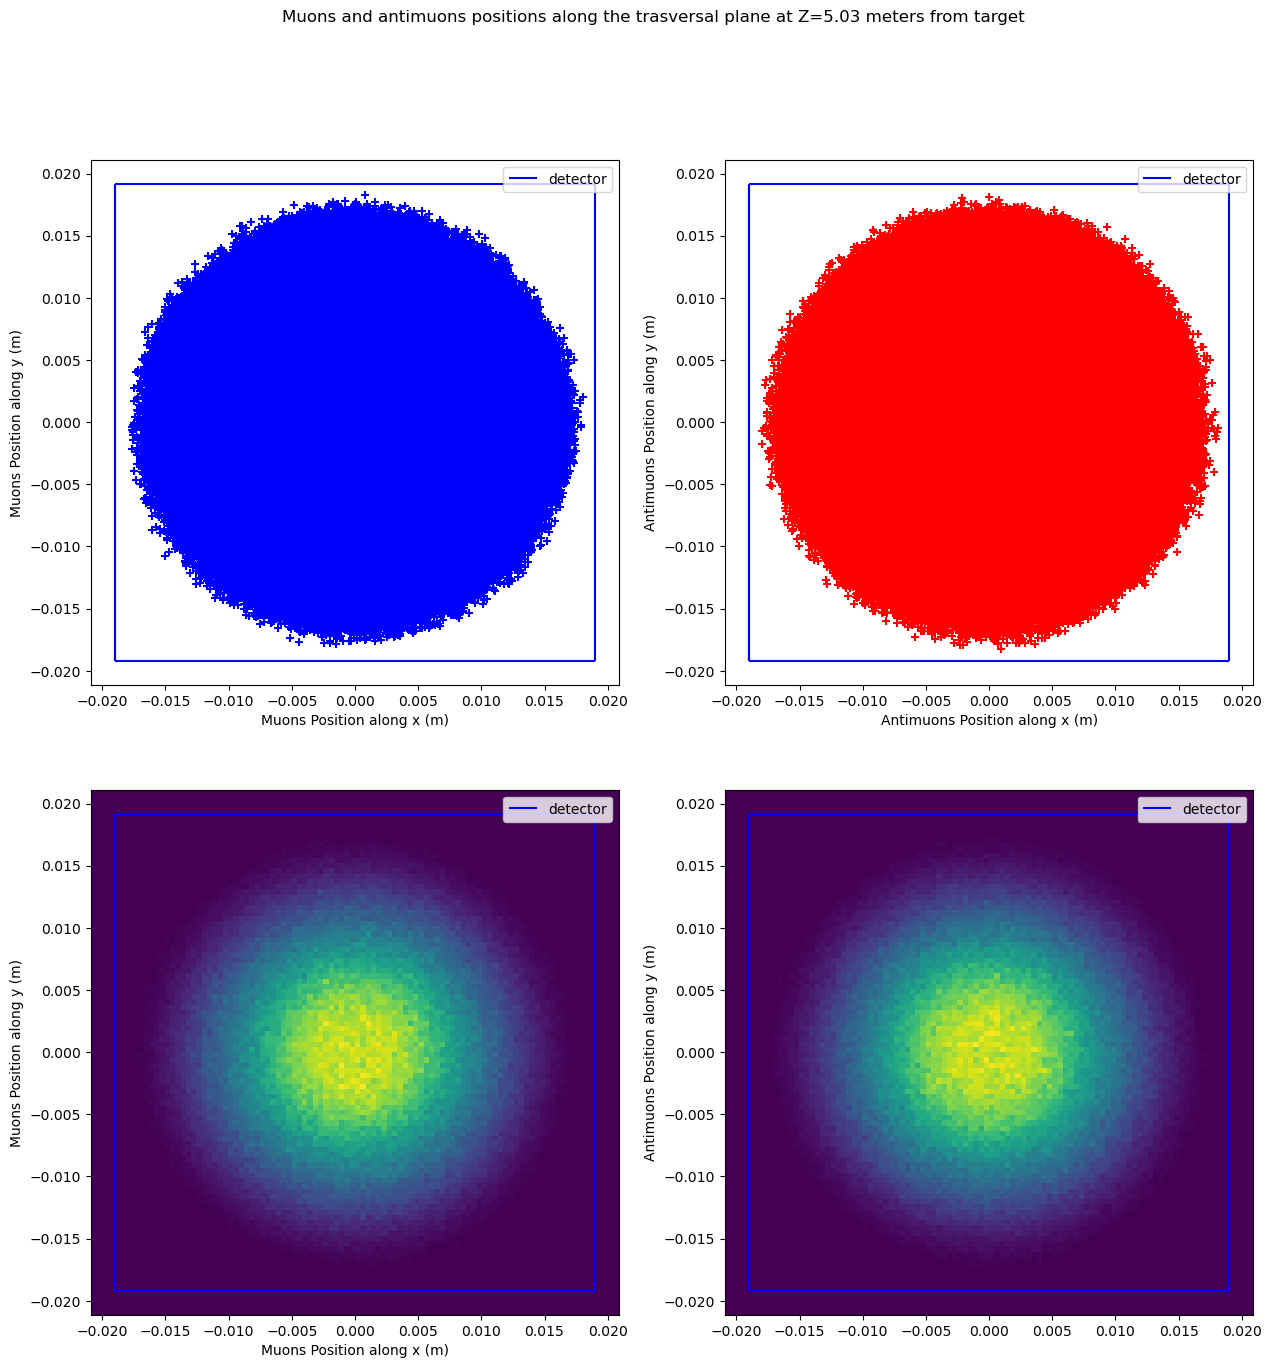

In order to contain the beam, we can use a detector with a x side of 0.038 m
In order to contain the beam, we can use a detector with a y side of 0.038 m
Using 50 μm pixels, the percentage of indistinguishable muon pairs is: 0.0013%


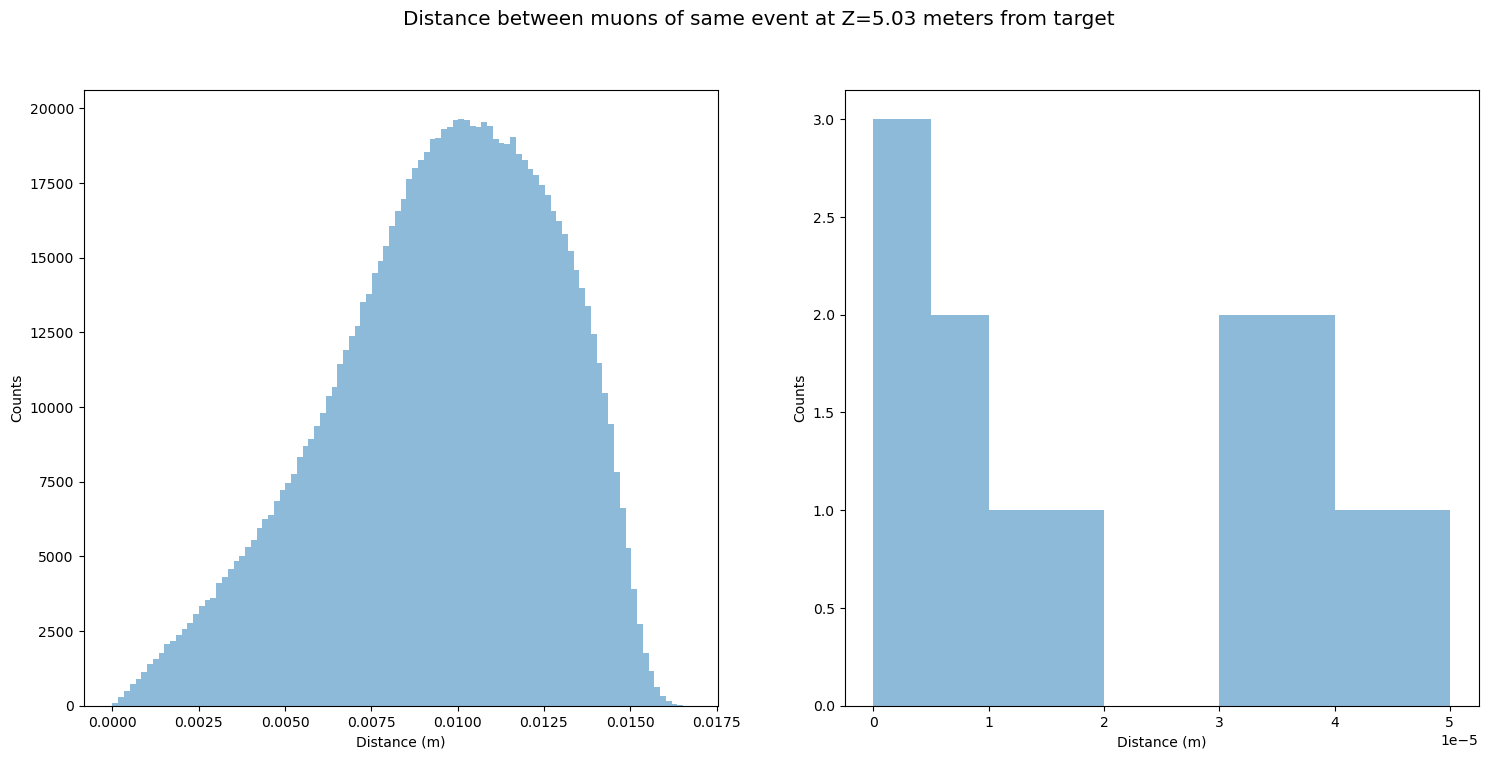

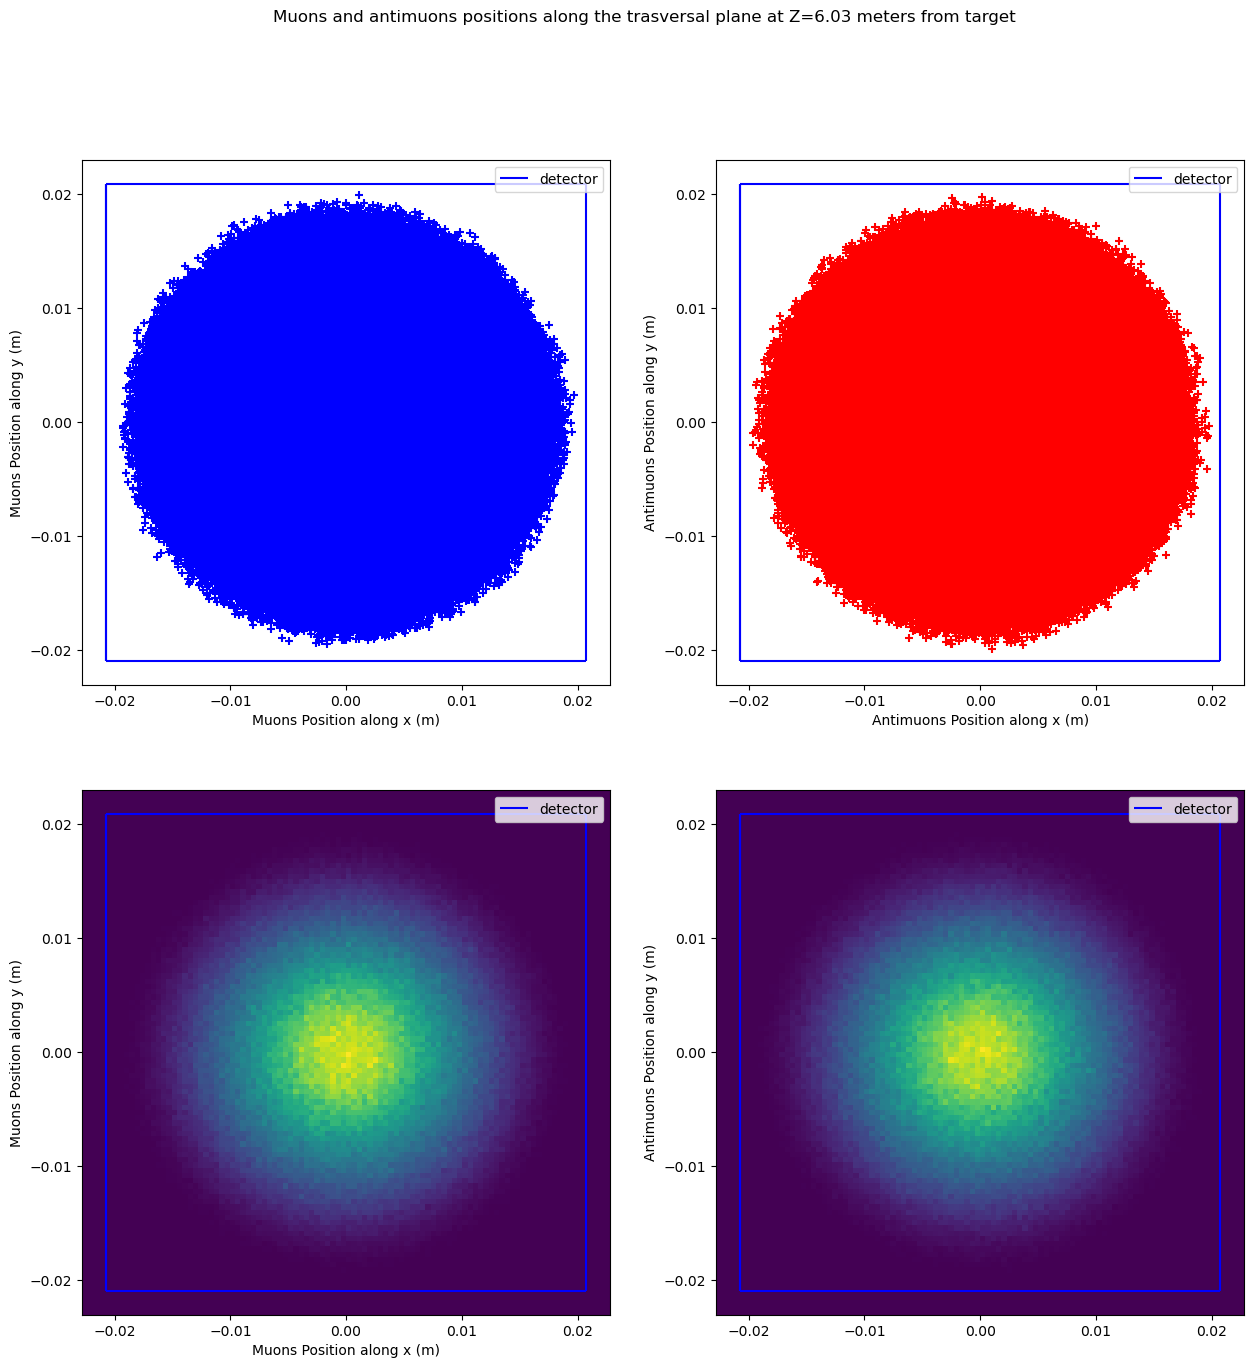

In order to contain the beam, we can use a detector with a x side of 0.041 m
In order to contain the beam, we can use a detector with a y side of 0.042 m
Using 50 μm pixels, the percentage of indistinguishable muon pairs is: 0.0012%


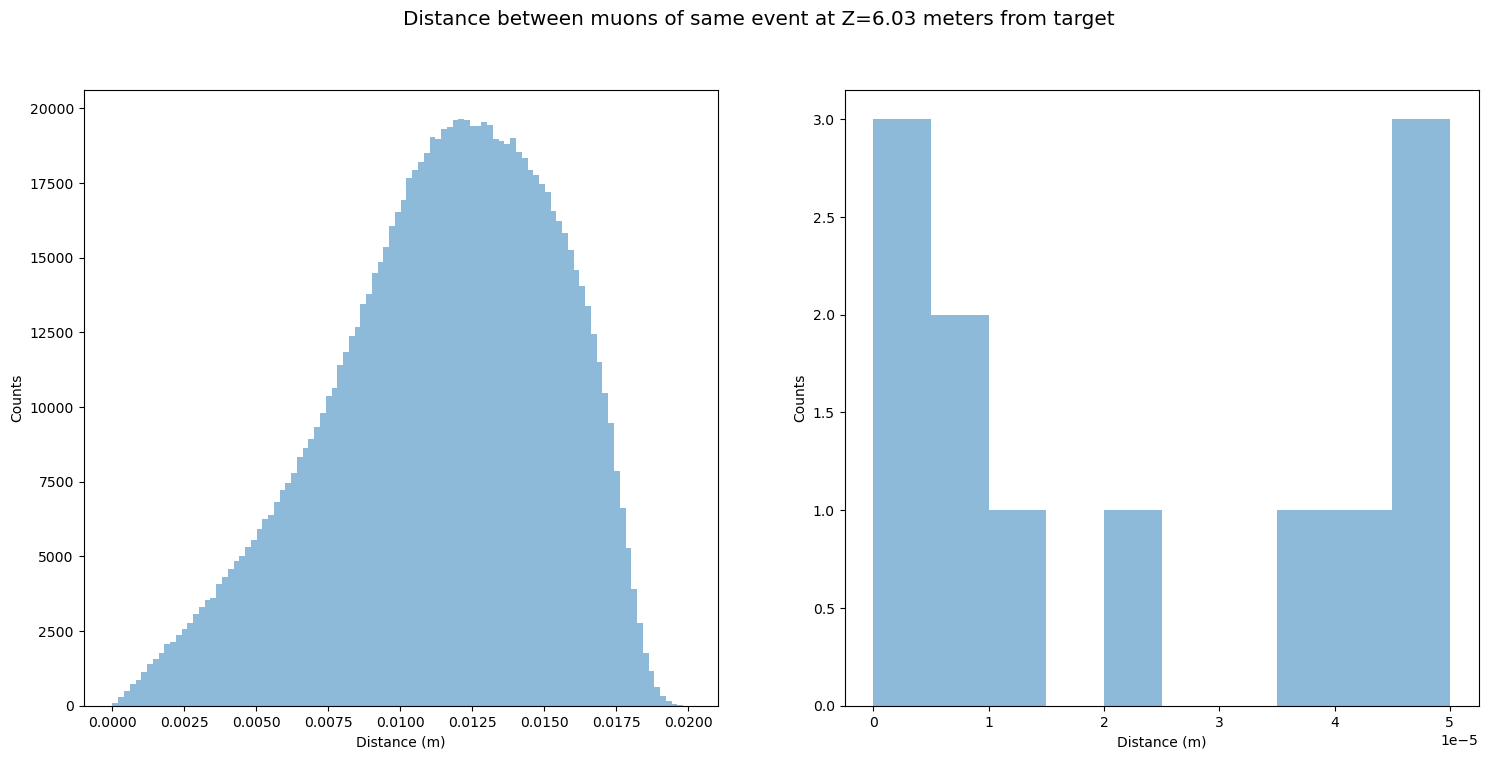

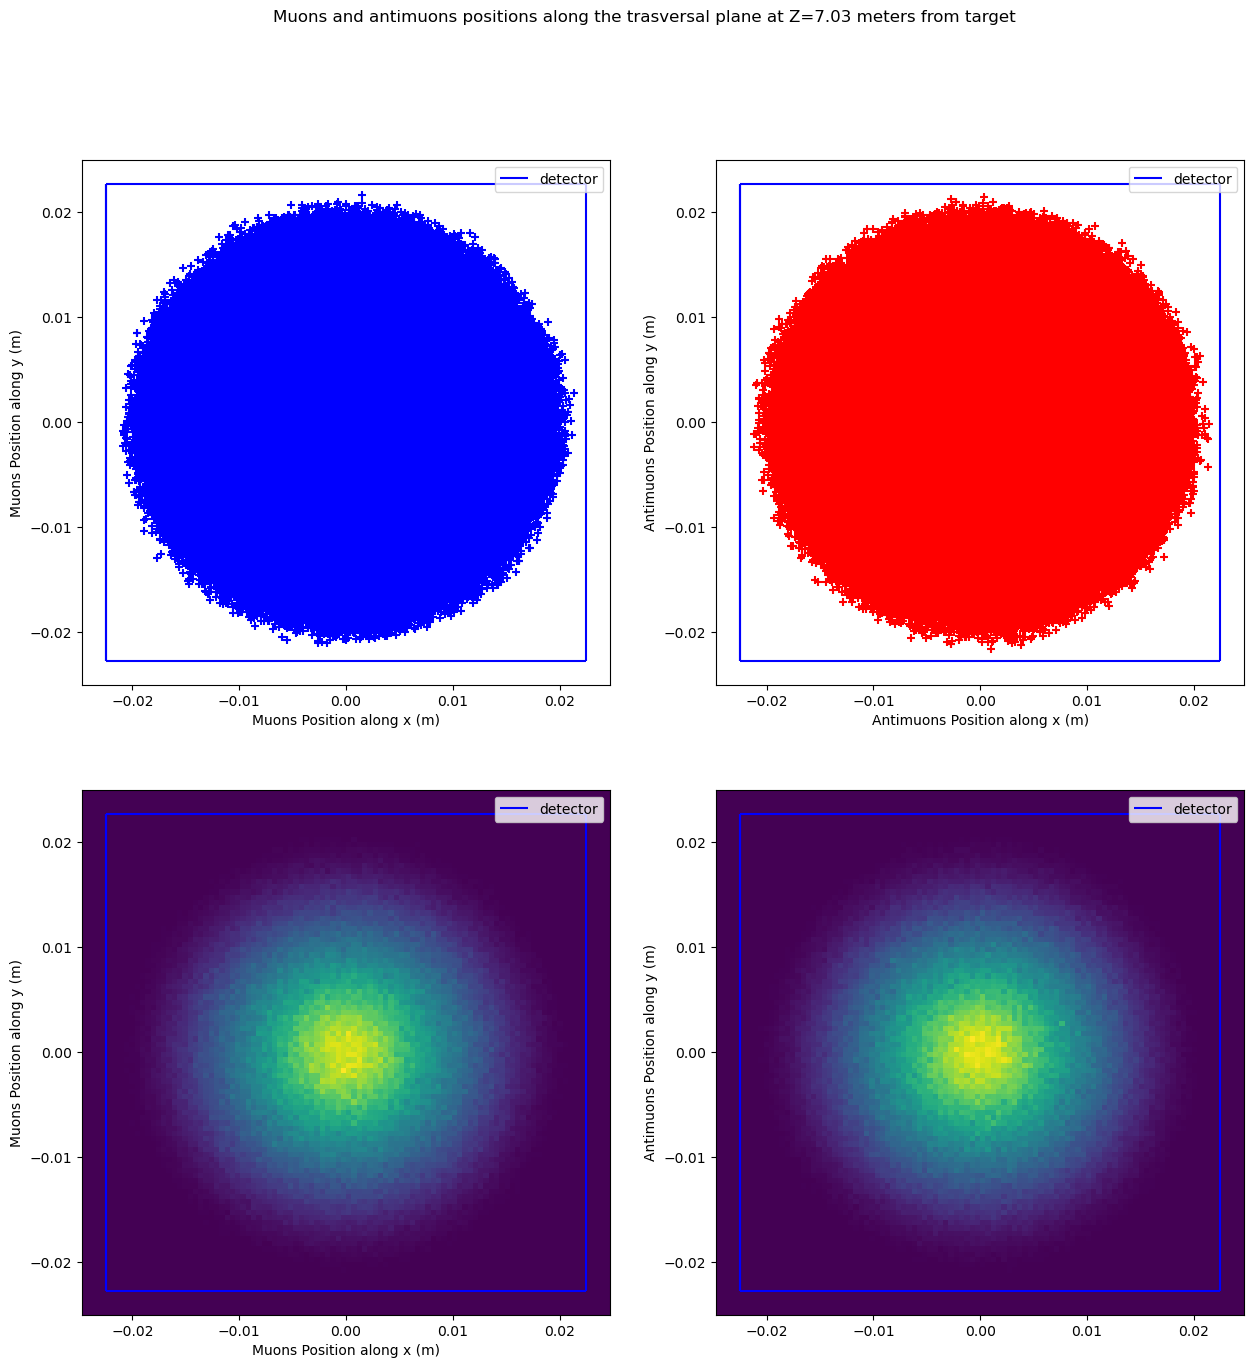

In order to contain the beam, we can use a detector with a x side of 0.045 m
In order to contain the beam, we can use a detector with a y side of 0.045 m
Using 50 μm pixels, the percentage of indistinguishable muon pairs is: 0.0009%


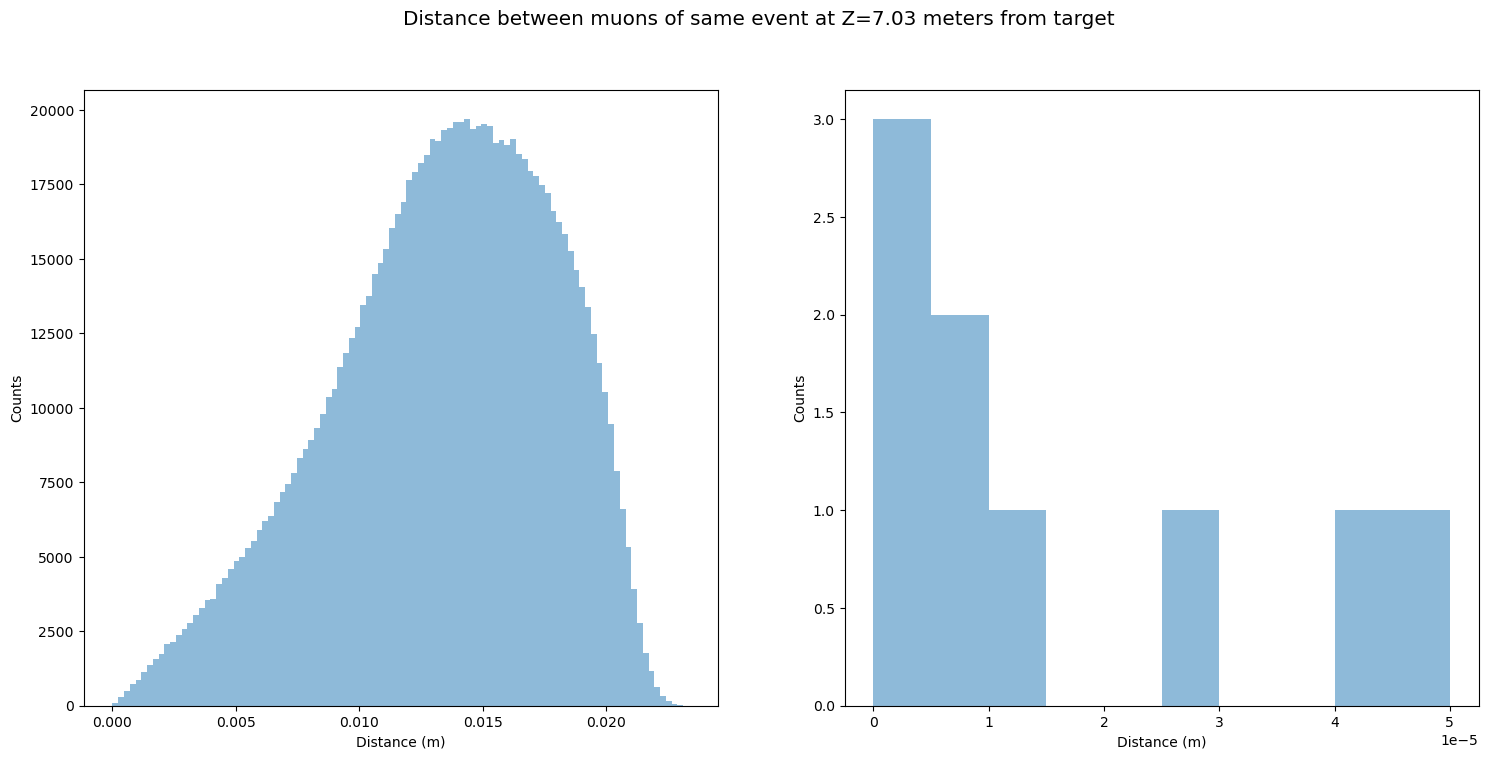

In [ ]:
#detector positions
Position_mu_n = pd.DataFrame()
Position_mu_p = pd.DataFrame()

for i in [3,4,5]:
    Z_det = detector['z[m]'][i]
    
    ######################
    ### negative muons ###
    ######################
    
    tn=(Z_det-Z)/(Pz_mu1/mu_mass*c)   
    xn=X+(Px_mu1/mu_mass*c)*tn    
    yn=Y+(Py_mu1/mu_mass*c)*tn
    
    ######################
    ### positive muons ###
    ######################
    
    tp=(Z_det-Z)/Pz_mu2
    xp=X+Px_mu2*tp
    yp=Y+Py_mu2*tp

    
    
    ###########################
    ### detector boundaries ###
    ###########################
    
    center_x = np.mean(np.hstack((xn, xp)))
    center_y = np.mean(np.hstack((yn, yp)))
    l_x = 2*np.max(np.abs( np.hstack((xn, xp)) - center_x )*1.05)
    l_y = 2*np.max(np.abs( np.hstack((yn, yp)) - center_y )*1.05)
    
    detector['x_center[m]'][i] = np.round(center_x, 4)
    detector['y_center[m]'][i] = np.round(center_y, 4)
    detector['x_length[m]'][i] = np.round(l_x, 3)
    detector['y_length[m]'][i] = np.round(l_y, 3)
    
    
    
    fig, ((ax1,ax2),(ax3, ax4))=plt.subplots(2,2,figsize=(15,15))
    fig.suptitle('Muons and antimuons positions along the trasversal plane at Z={} meters from target'.format(Z_det))
    
        
    #particle positions
    ax1.scatter(xn,yn,color='blue',marker='+')
    ax1.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax1.vlines(center_x+l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax1.hlines(center_y-l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')    
    ax1.hlines(center_y+l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')
    ax1.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, label='detector', color='b')
    ax1.set_xlabel("Muons Position along x (m)")
    ax1.set_ylabel("Muons Position along y (m)")
    ax1.legend()
    
    #particle positions
    ax2.scatter(xp,yp,color='red',marker='+')
    ax2.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax2.vlines(center_x+l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax2.hlines(center_y-l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')    
    ax2.hlines(center_y+l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')
    ax2.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, label='detector', color='b')
    ax2.set_xlabel("Antimuons Position along x (m)")
    ax2.set_ylabel("Antimuons Position along y (m)")
    ax2.legend()
    
    ax3.hist2d(xn, yn, bins=(100, 100), range=[[center_x-(l_x/2)*1.1 , center_x+(l_x/2)*1.1 ],
                                             [center_y-(l_y/2)*1.1 , center_y+(l_y/2)*1.1]])
    ax3.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax3.vlines(center_x+l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax3.hlines(center_y-l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')    
    ax3.hlines(center_y+l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')
    ax3.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, label='detector', color='b')
    ax3.set_xlabel("Muons Position along x (m)")
    ax3.set_ylabel("Muons Position along y (m)")
    ax3.legend()
    

    ax4.hist2d(xp, yp, bins=(100, 100), range=[[center_x-(l_x/2)*1.1 , center_x+(l_x/2)*1.1 ],
                                             [center_y-(l_y/2)*1.1 , center_y+(l_y/2)*1.1]])
    ax4.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax4.vlines(center_x+l_x/2, center_y-l_y/2, center_y+l_y/2, color='b')
    ax4.hlines(center_y-l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')    
    ax4.hlines(center_y+l_y/2, center_x-l_x/2, center_x+l_x/2, color='b')
    ax4.set_ylabel("Antimuons Position along y (m)")
    ax4.vlines(center_x-l_x/2, center_y-l_y/2, center_y+l_y/2, label='detector', color='b')
    ax4.legend()
    
    plt.show() 
    
    Position_mu_n['mu-_X_{}'.format(Z_det)] = xn
    Position_mu_n['mu-_Y_{}'.format(Z_det)] = yn
    Position_mu_n['mu-_Z_{}'.format(Z_det)] = Z_det*np.ones(NEvents)
    
    Position_mu_p['mu+_X_{}'.format(Z_det)] = xp
    Position_mu_p['mu+_Y_{}'.format(Z_det)] = yp
    Position_mu_p['mu+_Z_{}'.format(Z_det)] = Z_det*np.ones(NEvents)
    

    print("In order to contain the beam, we can use a detector with a x side of {:.3f} m".format(l_x))
    print("In order to contain the beam, we can use a detector with a y side of {:.3f} m".format(l_y))
    
    #########################
    ### study of smearing ###
    #########################

    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,8))
    fig.suptitle('Distance between muons of same event at Z={} meters from target'.format(Z_det),fontsize='x-large')
    
    dist=np.sqrt((xp-xn)**2+(yp-yn)**2)
    
    ax1.hist(dist,bins=100,alpha = 0.5, lw=3)
    ax1.set_xlabel("Distance (m)")
    ax1.set_ylabel("Counts")

    #histogram stopped at 50 µm
    ax2.hist(dist,range=[0,0.00005],alpha = 0.5, lw=3)
    ax2.set_xlabel("Distance (m)")
    ax2.set_ylabel("Counts")
    masked_dist = dist[dist<50e-6]    
    percentage= len(masked_dist)/len(dist)
    print("Using 50 μm pixels, the percentage of indistinguishable muon pairs is: "+str(round(percentage*100,4))+"%")
    plt.show()

It is shown that we can use detectors with the following geometrical stats:
 1. Z=5.03 m - side=0.038 m
 2. Z=6.03 m - side=0.042 m
 3. Z=7.03 m - side=0.045 m

Taking 50 µm as the pixel size, it is verified that it is possible to separate approximately 100% of the pairs. Moreover, the farther we move from the scattering site, the larger the particles become, thus pair detection is simple. Although we can reduce the number of unseparated pairs placing the first detector far from the target, but this is a solution that doen't take into account that the farther away we put the detectors, the larger they have to be to have 100% acceptance.

The shapes above represent the positions of muons and antimuons in the transversal plane at a particular distance from the target. The specific positions are calculated using the particle's equation of motion.

The two histograms in the bottom row of the plot show the distribution of muons and antimuons in the transversal plane. The blue histogram shows the distribution of muons and the red histogram shows the distribution of antimuons. The histograms are two-dimensional and show the number of particles in each small rectangular bin. The position of the detector is indicated by the blue rectangle in the histograms.

The blue and red crosses in the top row of the plot represent the positions of negative muons and positive muons, respectively. The blue rectangles represent the position of the detector for negative muons and positive muons. The width and height of the detector rectangle represent the length of the detector in the x and y directions.

The histograms and particle positions in the transversal plane provide information about the spatial distribution of muons and antimuons at a particular distance from the target. The dimensions and position of the detector can be adjusted to optimize the collection of muons and antimuons for a particular experiment.

### After the magnet - muon beams

First of all we have to evaluate the cinematic properties of the muons and the antimuons after the magnet.
When muons and antimuons move through a magnetic field, they experience a force due to the interaction between their charge and the magnetic field. This force causes the muons and antimuons to move in circular paths. The muon follows a circular path until it exits the magnetic field, at which point its trajectory becomes linear again.

The equation that describes the force experienced by a charged particle moving in a magnetic field is known as the Lorentz force equation:

$$\overline{F} = q\overline{v} x \overline{B}$$

Where F is the force on the particle, q is its charge, v is its velocity, and B is the magnetic field. The term (v x B) represents the cross product of the velocity and magnetic field vectors.

For a muon or antimuon moving in a magnetic field, the force will be perpendicular to both the xz component of particle's velocity and the magnetic field direction. This causes the particle to move in a circular path, with the radius of the circle determined by the speed of the particle and the strength of the magnetic field. The center of the circular path is determined based on the initial position and momentum of the muon.

The equation that describes the radius of the circular path is:

$$ r = \frac{m|\overline{v}|}{q|\overline{B}|}$$



Where r is the radius of the circular path, m is the mass of the particle, and v is its velocity. This equation shows that the radius of the path is proportional to the particle's momentum (mv) and inversely proportional to the strength of the magnetic field (B). 
The direction of the momentum vector changes as the muon follows the curved path in the magnetic field. This change in momentum is described by the angle of deflection, which is proportional to the magnitude of the magnetic field and the distance traveled by the particle.

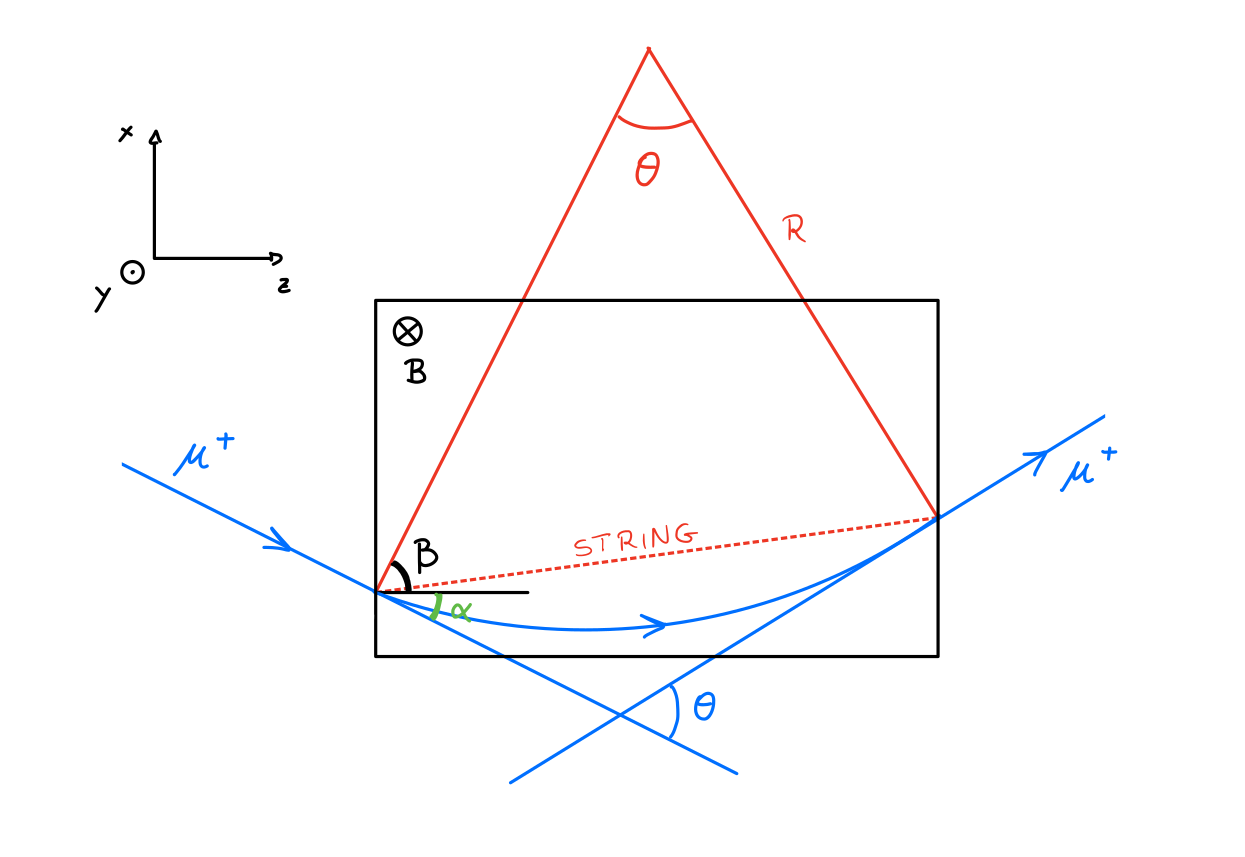

In [ ]:
Image("Particles_magnet.png",width=800,height=400)

In [ ]:
B=1.7 #Tesla       ####   direction of magnetic field  #####
L=3 #meters  
Z_mag = 8.03


#########################
#### Positive muons #####
#########################

#initial momenta and circ radiuses
P_pos=np.sqrt(Px_mu2**2+Pz_mu2**2)
R_pos=P_pos/(B*0.3)          
Circ_center=np.zeros((NEvents,2))

#initial positions
Z_init_pos=np.ones(NEvents)*Z_mag
t=(Z_init_pos-Z)/Pz_mu2

X_init_pos=X+Px_mu2*t
Y_init_pos=Y+Py_mu2*t

#Circ center
alpha=np.arccos(Pz_mu2/P_pos)
beta=np.pi/2-alpha

Circ_center[:,0][Px_mu2>=0]=(X_init_pos+R_pos*np.sin(beta))[Px_mu2>=0]
Circ_center[:,1][Px_mu2>=0]=(Z_init_pos-R_pos*np.cos(beta))[Px_mu2>=0]
   
Circ_center[:,0][Px_mu2<0]=(X_init_pos+R_pos*np.sin(beta))[Px_mu2<0]
Circ_center[:,1][Px_mu2<0]=(Z_init_pos+R_pos*np.cos(beta))[Px_mu2<0]

#positions after the magnet
Pos_mupos=np.zeros((NEvents,3))

Pos_mupos[:,0]= Circ_center[:,0]-np.sqrt(R_pos**2-((Z_init_pos+L)-Circ_center[:,1])**2)  # x
Pos_mupos[:,2]= Z_init_pos+L    # z

string=np.sqrt((Pos_mupos[:,0]-X_init_pos)**2+(Pos_mupos[:,2]-Z_init_pos)**2)
theta=2*np.arcsin(string/(2*R_pos))

k=R_pos*theta/P_pos
Pos_mupos[:,1]=Py_mu2*k+Y_init_pos    # y  

#momenta
Momenta_mupos=np.zeros((NEvents,3))

Momenta_mupos[:,0]=np.cos(theta)*Px_mu2+np.sin(theta)*Pz_mu2
Momenta_mupos[:,1]=Py_mu2
Momenta_mupos[:,2]=np.cos(theta)*Pz_mu2-np.sin(theta)*Px_mu2



#########################
#### Negative muons #####
#########################

#initial momenta and circ radiuses
P_neg=np.sqrt(Px_mu1**2+Pz_mu1**2)
R_neg=P_neg/(B*0.3)
Circ_center=np.empty((NEvents,2))

#initial positions
Z_init_neg=np.ones(NEvents)*Z_mag
t=(Z_init_neg-Z)/Pz_mu1

X_init_neg=X+Px_mu1*t
Y_init_neg=Y+Py_mu1*t

#Circ center
alpha=np.arccos(Pz_mu1/P_neg)
beta=np.pi/2-alpha

Circ_center[:,0][Px_mu1>=0]=(X_init_neg-R_neg*np.sin(beta))[Px_mu1>=0]
Circ_center[:,1][Px_mu1>=0]=(Z_init_neg+R_neg*np.cos(beta))[Px_mu1>=0]
   
Circ_center[:,0][Px_mu1<0]=(X_init_neg-R_neg*np.sin(beta))[Px_mu1<0]
Circ_center[:,1][Px_mu1<0]=(Z_init_neg-R_neg*np.cos(beta))[Px_mu1<0]

#positions after the magnet
Pos_muneg=np.zeros((NEvents,3))

Pos_muneg[:,0]= Circ_center[:,0]+np.sqrt(R_neg**2-((Z_init_neg+L)-Circ_center[:,1])**2)  # x
Pos_muneg[:,2]= Z_init_neg+L    # z

string=np.sqrt((Pos_muneg[:,0]-X_init_neg)**2+(Pos_muneg[:,2]-Z_init_neg)**2)
theta=2*np.arcsin(string/(2*R_neg))

k=R_neg*theta/P_neg                   # time inside the magnet
Pos_muneg[:,1]=Py_mu1*k+Y_init_neg    # y  

#momenta
Momenta_muneg=np.zeros((NEvents,3))

Momenta_muneg[:,0]=np.cos(-theta)*Px_mu1+np.sin(-theta)*Pz_mu1
Momenta_muneg[:,1]=Py_mu1
Momenta_muneg[:,2]=np.cos(-theta)*Pz_mu1-np.sin(-theta)*Px_mu1

Now we can use the EOM of the muons and the antimuons in order to complete the geometrical definition of the experiment.

In [ ]:
Position_mu_n_after_mag = pd.DataFrame()
Position_mu_p_after_mag = pd.DataFrame()


 
 
 
                                             Detector in z position: 12.43m
For muons
 - center position in [ -0.194 , 0.0 ] 
 - dimension [ 0.197 , 0.065 ] 

For antimuons
 - center position in [ 0.1941 , -0.0 ] 
 - dimension [ 0.197 , 0.065 ] 



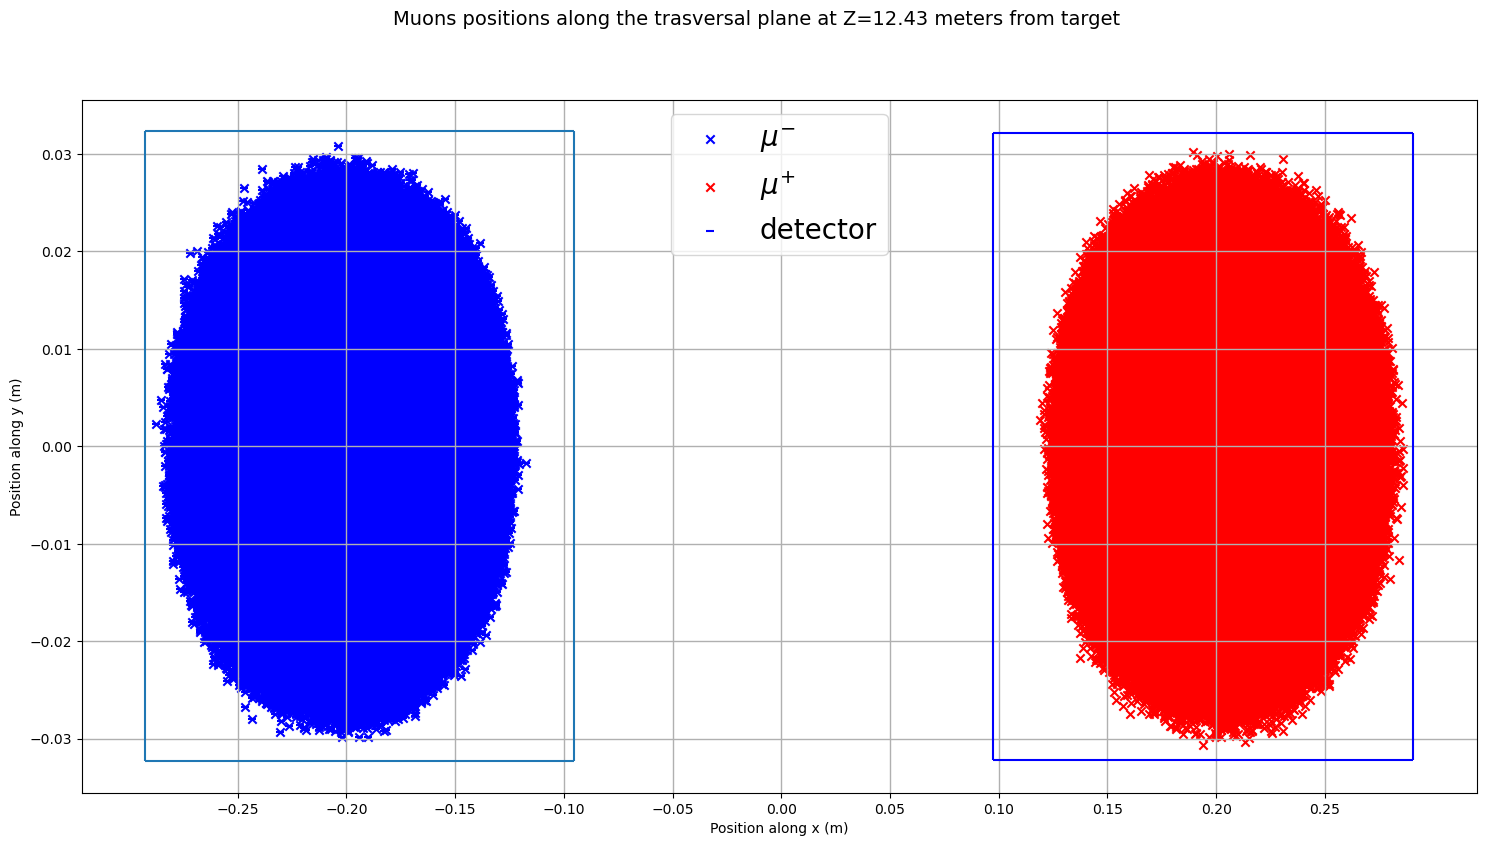

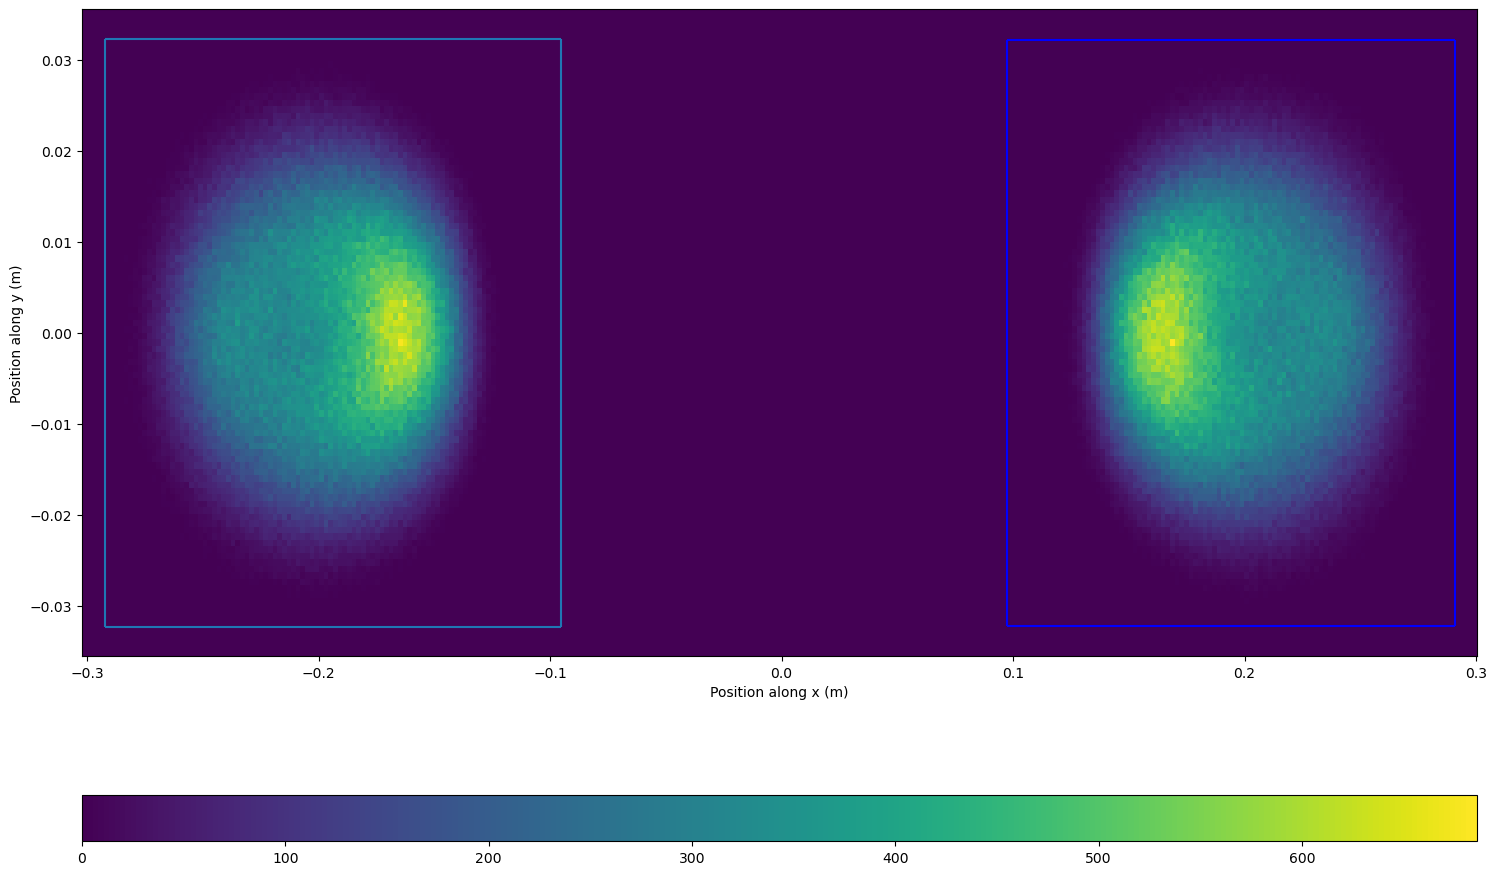


 
 
 
                                             Detector in z position: 13.43m
For muons
 - center position in [ -0.2609 , 0.0 ] 
 - dimension [ 0.256 , 0.068 ] 

For antimuons
 - center position in [ 0.261 , -0.0 ] 
 - dimension [ 0.256 , 0.068 ] 



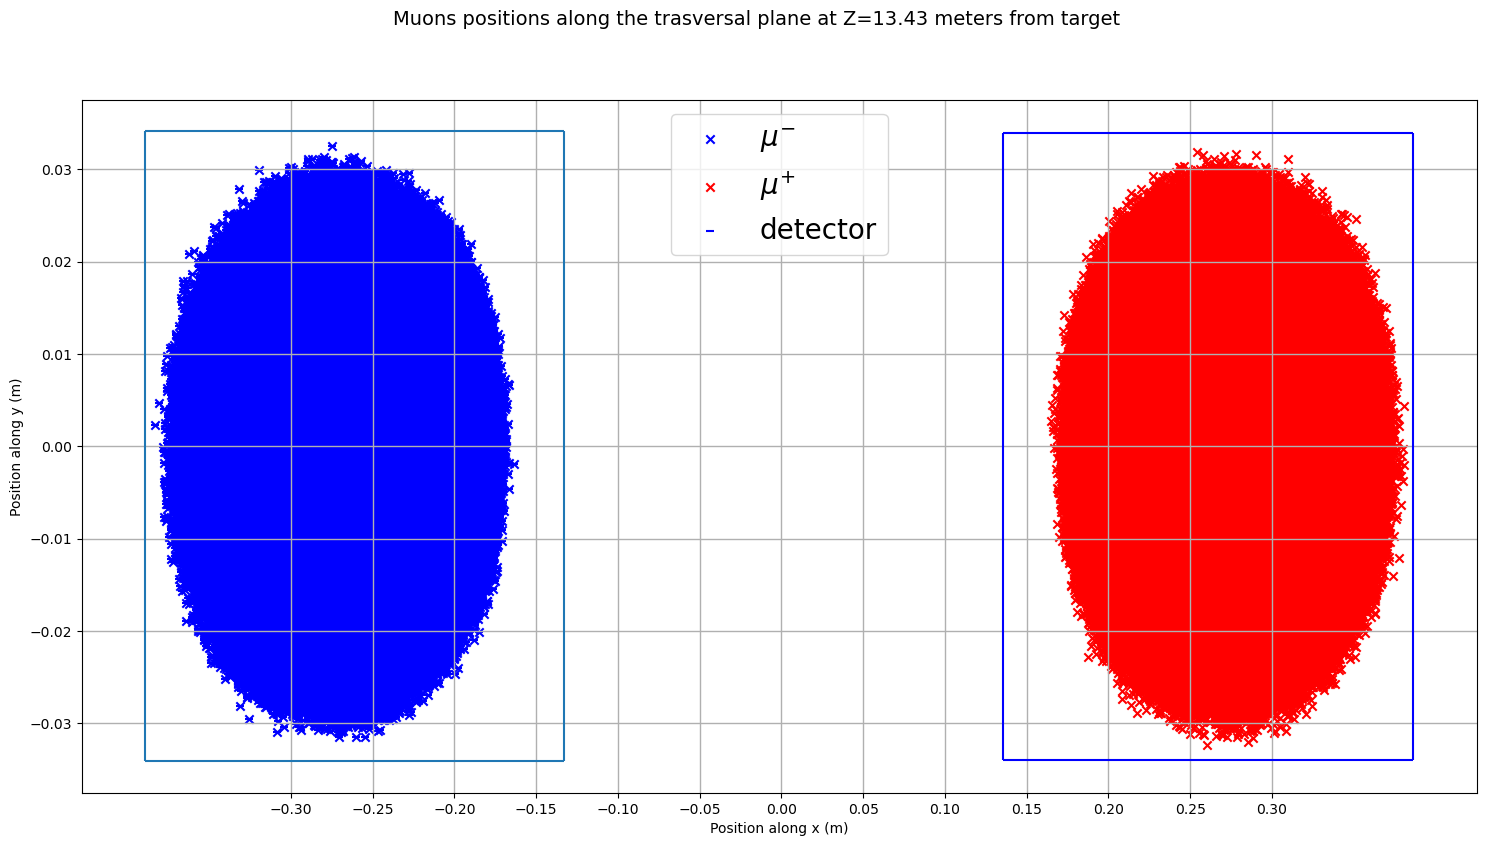

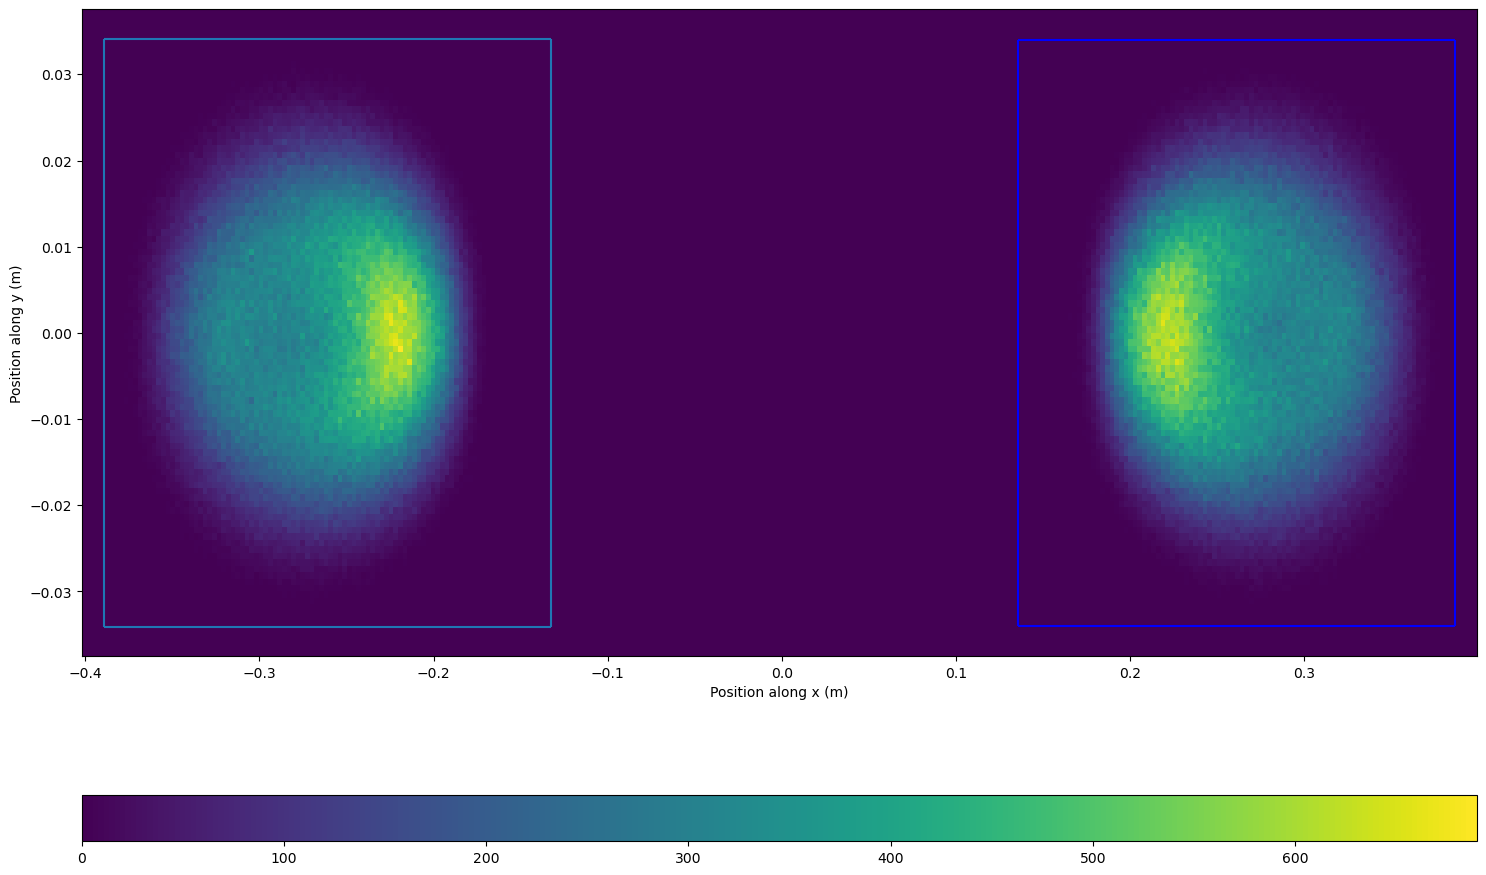


 
 
 
                                             Detector in z position: 14.43m
For muons
 - center position in [ -0.3279 , 0.0 ] 
 - dimension [ 0.316 , 0.072 ] 

For antimuons
 - center position in [ 0.328 , -0.0 ] 
 - dimension [ 0.316 , 0.072 ] 



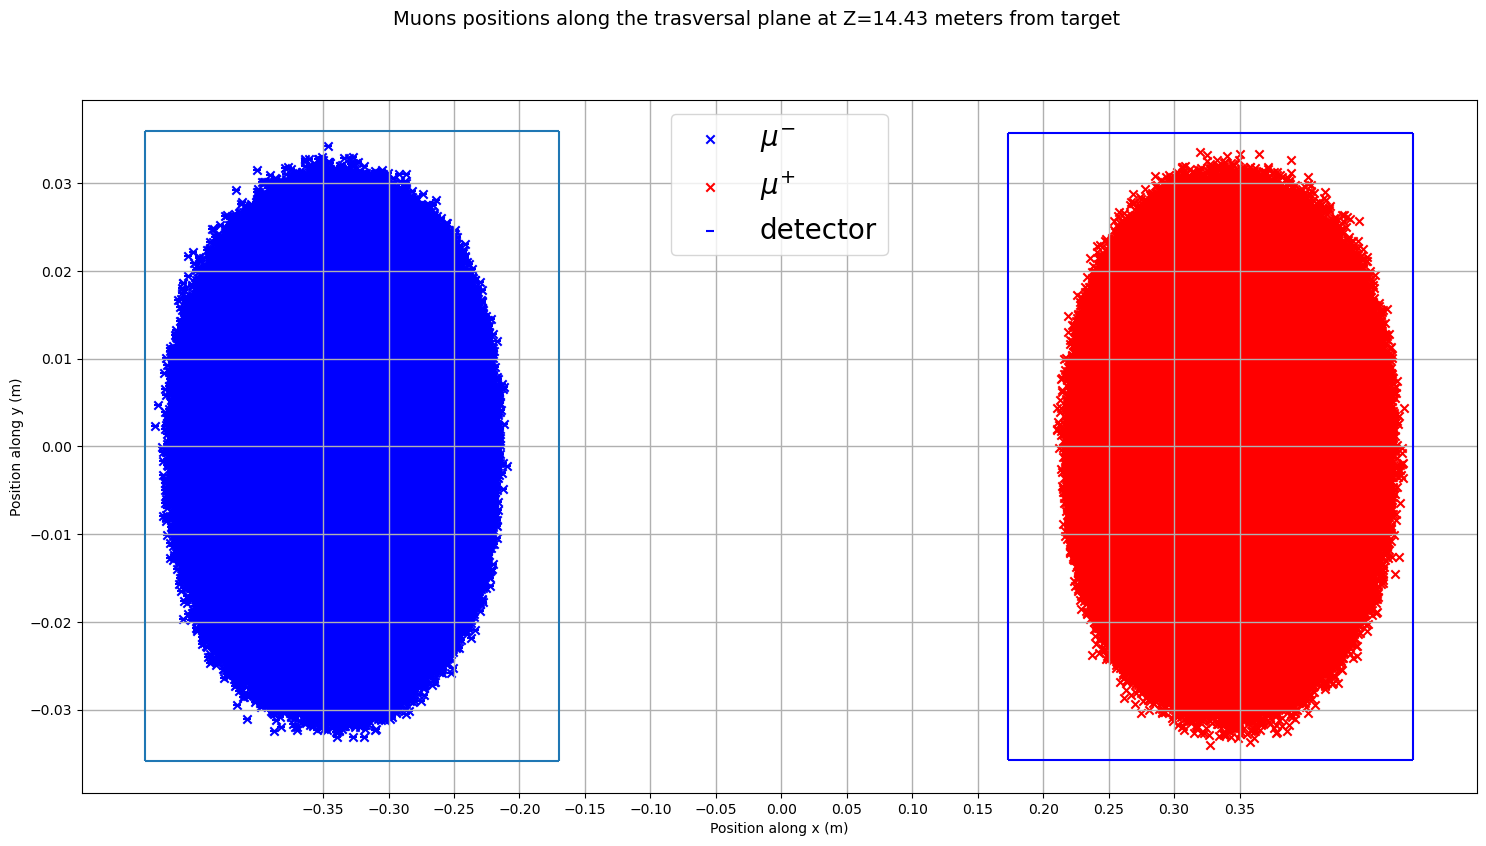

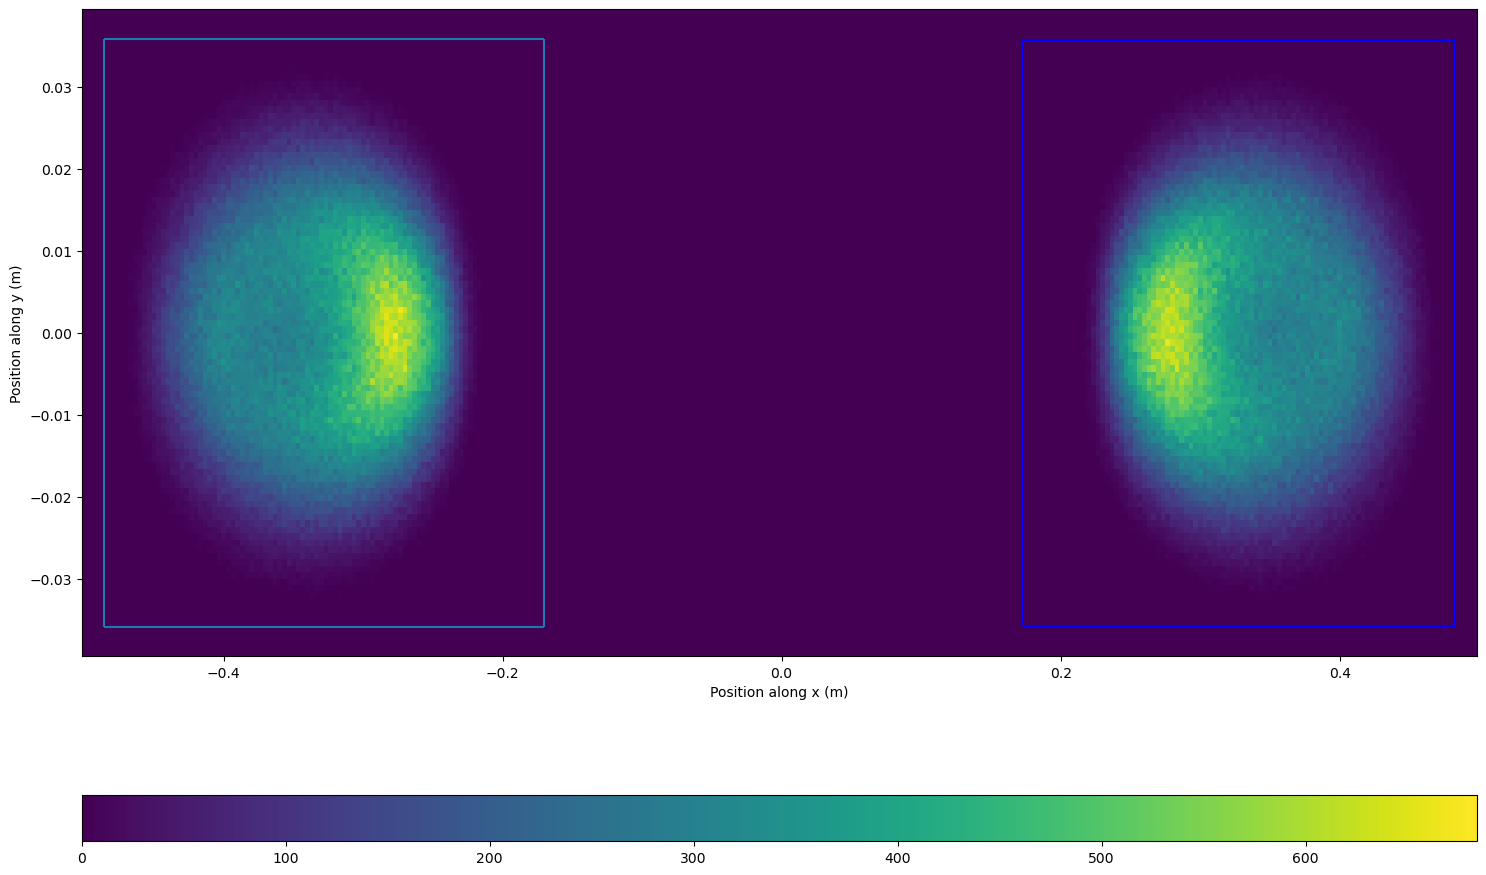

In [ ]:
#solve same equations as before to get where they hit final detectors after magnet

s=0
for i in [6,7,8]:
    Z_det = detector['z[m]'][i]
    
    #negative muons
    tn=(Z_det-Pos_muneg[:,2])/Momenta_muneg[:,2]   
    xn=Pos_muneg[:,0]+Momenta_muneg[:,0]*tn   
    yn=Pos_muneg[:,1]+Momenta_muneg[:,1]*tn
    
    Position_mu_n_after_mag['mu-_X_{}'.format(Z_det)] = xn
    Position_mu_n_after_mag['mu-_Y_{}'.format(Z_det)] = yn
    Position_mu_n_after_mag['mu-_Z_{}'.format(Z_det)] = Z_det*np.ones(NEvents)
    
    #positive muons
    tp=(Z_det-Pos_mupos[:,2])/Momenta_mupos[:,2] 
    xp=Pos_mupos[:,0]+Momenta_mupos[:,0]*tp
    yp=Pos_mupos[:,1]+Momenta_mupos[:,1]*tp
    
    Position_mu_p_after_mag['mu+_X_{}'.format(Z_det)] = xp
    Position_mu_p_after_mag['mu+_Y_{}'.format(Z_det)] = yp
    Position_mu_p_after_mag['mu+_Z_{}'.format(Z_det)] = Z_det*np.ones(NEvents)
    
    
    # detectors for muons
    center_x_n = np.mean(xn)
    center_y_n = np.mean(yn)
    l_x_n = 2*np.max(np.abs( xn - center_x_n )*1.05)
    l_y_n = 2*np.max(np.abs( yn - center_y_n )*1.05)
    
    detector['x_center[m]'][i] = np.round(center_x_n, 4)
    detector['y_center[m]'][i] = np.round(center_y_n, 4)
    

    # detectors for antimuons
    center_x_p = np.mean(xp)
    center_y_p = np.mean(yp)
    l_x_p = 2*np.max(np.abs( xp - center_x_p )*1.05)
    l_y_p = 2*np.max(np.abs( yp - center_y_p )*1.05)
    
    detector['x_center[m]'][i+3] = np.round(center_x_p, 4)
    detector['y_center[m]'][i+3] = np.round(center_y_p, 4)
    
    
    
    # since we want symmetric detectors and we take the max value between muon and antimuons dimension
    detector['x_length[m]'][i] = detector['x_length[m]'][i+3] = max(np.round(l_x_n, 3), np.round(l_x_p, 3))
    detector['y_length[m]'][i] = detector['y_length[m]'][i+3] = max(np.round(l_y_n, 3), np.round(l_y_p, 3))
    
    
    print('\n', '\n', '\n', '\n', '                                            Detector in z position: '+ str(Z_det)+'m')
    print('For muons')
    print(' - center position in [', np.round(center_x_n, 4),',', np.round(center_y_n, 4),
          ']', '\n','- dimension [', detector['x_length[m]'][i],',', detector['y_length[m]'][i], ']' , '\n')
    
    print('For antimuons')
    print(' - center position in [', np.round(center_x_p, 4),',', np.round(center_y_p, 4),
          ']', '\n','- dimension [', detector['x_length[m]'][i+3],',', detector['y_length[m]'][i+3], ']' , '\n')
    
    
    fig, ax=plt.subplots(1,1,figsize=(18,9))
    fig.suptitle('Muons positions along the trasversal plane at Z={} meters from target'.format(Z_det), fontsize=14)
        
    #muon detectors
    ax.vlines(center_x_n-l_x_n/2, 
              center_y_n-l_y_n/2, 
              center_y_n+l_y_n/2)
    
    ax.vlines(center_x_n+l_x_n/2, 
              center_y_n-l_y_n/2, 
              center_y_n+l_y_n/2)

    ax.hlines(center_y_n-l_y_n/2, 
              center_x_n-l_x_n/2, 
              center_x_n+l_x_n/2)
    
    ax.hlines(center_y_n+l_y_n/2, 
              center_x_n-l_x_n/2, 
              center_x_n+l_x_n/2)

    
    #antimuon detectors
    ax.vlines(center_x_p-l_x_p/2, 
              center_y_p-l_y_p/2, 
              center_y_p+l_y_p/2, color='blue')
    
    ax.vlines(center_x_p+l_x_p/2, 
              center_y_p-l_y_p/2, 
              center_y_p+l_y_p/2, color='blue')

    ax.hlines(center_y_p-l_y_p/2, 
              center_x_p-l_x_p/2, 
              center_x_p+l_x_p/2, color='blue')
    
    ax.hlines(center_y_p+l_y_p/2, 
              center_x_p-l_x_p/2, 
              center_x_p+l_x_p/2, color='blue')
    
    
    ax.scatter(xn,yn,color='blue',marker='x',label="$\mu^{-}$")
    ax.scatter(xp,yp,color='red',marker='x',label="$\mu^{+}$")
    ax.scatter(xn,yn,color='blue',marker='_',label="detector")
    
    ticksx=np.arange(-(0.25+s*0.05),0.3+s*0.05,0.05)
    ax.set_xticks(ticksx)
    ax.set_xlabel("Position along x (m)")
    ax.set_ylabel("Position along y (m)")
    ax.grid(which='both', linewidth=1)
    ax.legend(loc=9,prop={'size': 20})
    s+=1
    
    plt.show()
    
    plt.figure(figsize=(18,12))    
    plt.hist2d(np.hstack((xn,xp)), np.hstack((yn,yp)), bins=(300, 100),
               range=[[center_x_n-(l_x_n/2)*1.1, center_x_p+(l_x_p/2)*1.1],
                      [center_y_n-(l_y_n/2)*1.1, center_y_n+(l_y_n/2)*1.1]])
    plt.colorbar(location='bottom', aspect=30)
    plt.xlabel("Position along x (m)")
    plt.ylabel("Position along y (m)")
    
    plt.vlines(center_x_n-l_x_n/2, center_y_n-l_y_n/2, center_y_n+l_y_n/2)
    plt.vlines(center_x_n+l_x_n/2, center_y_n-l_y_n/2, center_y_n+l_y_n/2)
    plt.hlines(center_y_n-l_y_n/2, center_x_n-l_x_n/2, center_x_n+l_x_n/2)
    plt.hlines(center_y_n+l_y_n/2, center_x_n-l_x_n/2, center_x_n+l_x_n/2)
    
    plt.vlines(center_x_p-l_x_p/2, center_y_p-l_y_p/2, center_y_p+l_y_p/2, color='blue')
    plt.vlines(center_x_p+l_x_p/2, center_y_p-l_y_p/2, center_y_p+l_y_p/2, color='blue')
    plt.hlines(center_y_p-l_y_p/2, center_x_p-l_x_p/2, center_x_p+l_x_p/2, color='blue')
    plt.hlines(center_y_p+l_y_p/2, center_x_p-l_x_p/2, center_x_p+l_x_p/2, color='blue')
    
    
    plt.show()

The plot shows us a rectangle that represents the transversal area of the detector. The sides of the rectangle are determined by the length of the muons and antimuons tracks in the transversal plane, and its center corresponds to the mean position of the muon and antimuon tracks in that plane.
For each muon and antimuon track: a blue (for muons) or red (for antimuons) cross marker representing the position of the muon or antimuon track in the transversal plane.
The purpose of the code is to simulate the behavior of muons and antimuons in a magnetic field and calculate the dimensions and center position of the detectors for detecting these particles in the transversal plane at a certain distance from the target. The shapes displayed in the figure help visualize the distribution of the muon and antimuon tracks in the transversal plane and the size and position of the detectors relative to them.

After this final test, we can see that the geometrical stats of the detectors are the following (meters):

(All below values are in meters)

* Muons:
 1. center=  (-0.1940 , 0.0 )     ,     dimensions=( 0.197 , 0.065 )
 2. center= ( -0.2609 , 0.0 )     ,     dimensions=( 0.256 , 0.068 )
 3. center= ( -0.3279 , 0.0 )     ,     dimensions=( 0.316 , 0.072 )


* Antimuons:
 1. center=  (0.1941 , 0.0 )     ,     dimensions=( 0.197 , 0.065 )
 2. center= ( 0.2610 , 0.0 )     ,     dimensions=( 0.256 , 0.068 )
 3. center= ( 0.3280 , 0.0 )     ,     dimensions=( 0.316 , 0.072 )


It follows the list of all the real positions of the particles through the detectors.

In [ ]:
#Positrons
Position_e_p

,e+_X_-0.31,e+_Y_-0.31,e+_Z_-0.31,e+_X_-0.16,e+_Y_-0.16,e+_Z_-0.16,e+_X_-0.01,e+_Y_-0.01,e+_Z_-0.01
0,0.006700,-0.000174,-0.31,0.006700,-0.000174,-0.16,0.006700,-0.000174,-0.01
1,-0.001808,0.005898,-0.31,-0.001808,0.005898,-0.16,-0.001808,0.005898,-0.01
2,0.001924,-0.004531,-0.31,0.001924,-0.004531,-0.16,0.001924,-0.004531,-0.01
3,0.007570,0.004268,-0.31,0.007570,0.004268,-0.16,0.007570,0.004268,-0.01
4,0.004862,-0.005216,-0.31,0.004862,-0.005216,-0.16,0.004862,-0.005216,-0.01
...,...,...,...,...,...,...,...,...,...
999995,-0.002064,-0.006667,-0.31,-0.002064,-0.006667,-0.16,-0.002064,-0.006667,-0.01
999996,-0.001824,-0.001494,-0.31,-0.001824,-0.001494,-0.16,-0.001824,-0.001494,-0.01
999997,0.002128,-0.000650,-0.31,0.002128,-0.000650,-0.16,0.002128,-0.000650,-0.01
999998,-0.000129,-0.003546,-0.31,-0.000129,-0.003546,-0.16,-0.000129,-0.003546,-0.01


In [ ]:
#Muons between
Position_mu_n

,mu-_X_5.03,mu-_Y_5.03,mu-_Z_5.03,mu-_X_6.03,mu-_Y_6.03,mu-_Z_6.03,mu-_X_7.03,mu-_Y_7.03,mu-_Z_7.03
0,0.011497,0.000886,5.03,0.012453,0.001097,6.03,0.013409,0.001309,7.03
1,0.005850,0.004638,5.03,0.007373,0.004388,6.03,0.008895,0.004137,7.03
2,0.002126,-0.008756,5.03,0.002166,-0.009598,6.03,0.002206,-0.010440,7.03
3,0.006950,0.001055,5.03,0.006826,0.000415,6.03,0.006703,-0.000225,7.03
4,0.012080,-0.004004,5.03,0.013519,-0.003763,6.03,0.014957,-0.003522,7.03
...,...,...,...,...,...,...,...,...,...
999995,0.000503,-0.004648,5.03,0.001015,-0.004245,6.03,0.001528,-0.003842,7.03
999996,-0.001153,0.002374,5.03,-0.001018,0.003147,6.03,-0.000884,0.003920,7.03
999997,0.004358,0.001220,5.03,0.004804,0.001594,6.03,0.005250,0.001968,7.03
999998,-0.004658,0.001604,5.03,-0.005561,0.002630,6.03,-0.006464,0.003657,7.03


In [ ]:
#Antimuons between
Position_mu_p

,mu+_X_5.03,mu+_Y_5.03,mu+_Z_5.03,mu+_X_6.03,mu+_Y_6.03,mu+_Z_6.03,mu+_X_7.03,mu+_Y_7.03,mu+_Z_7.03
0,0.000211,-0.001608,5.03,-0.001083,-0.001894,6.03,-0.002377,-0.002180,7.03
1,-0.006684,0.006701,5.03,-0.007653,0.006860,6.03,-0.008623,0.007020,7.03
2,0.001629,0.001659,5.03,0.001570,0.002892,6.03,0.001512,0.004125,7.03
3,0.007931,0.006140,5.03,0.008003,0.006513,6.03,0.008075,0.006886,7.03
4,-0.001069,-0.006211,5.03,-0.002251,-0.006409,6.03,-0.003433,-0.006608,7.03
...,...,...,...,...,...,...,...,...,...
999995,-0.005488,-0.009360,5.03,-0.006171,-0.009898,6.03,-0.006855,-0.010436,7.03
999996,-0.002645,-0.006225,5.03,-0.002809,-0.007170,6.03,-0.002973,-0.008115,7.03
999997,-0.000025,-0.002456,5.03,-0.000456,-0.002817,6.03,-0.000886,-0.003178,7.03
999998,0.003064,-0.007175,5.03,0.003700,-0.007898,6.03,0.004336,-0.008622,7.03


In [ ]:
#Muons after
Position_mu_n_after_mag

,mu-_X_12.43,mu-_Y_12.43,mu-_Z_12.43,mu-_X_13.43,mu-_Y_13.43,mu-_Z_13.43,mu-_X_14.43,mu-_Y_14.43,mu-_Z_14.43
0,-0.143735,0.002450,12.43,-0.198769,0.002662,13.43,-0.253803,0.002873,14.43
1,-0.213201,0.002783,12.43,-0.291161,0.002531,13.43,-0.369121,0.002280,14.43
2,-0.154490,-0.014989,12.43,-0.208578,-0.015832,13.43,-0.262666,-0.016675,14.43
3,-0.248303,-0.003687,12.43,-0.336217,-0.004329,13.43,-0.424130,-0.004971,14.43
4,-0.182167,-0.002217,12.43,-0.251425,-0.001975,13.43,-0.320683,-0.001733,14.43
...,...,...,...,...,...,...,...,...,...
999909,-0.165446,-0.001662,12.43,-0.223491,-0.001258,13.43,-0.281535,-0.000854,14.43
999910,-0.176895,0.008098,12.43,-0.237734,0.008873,13.43,-0.298572,0.009647,14.43
999911,-0.196355,0.003990,12.43,-0.266303,0.004365,13.43,-0.336250,0.004739,14.43
999912,-0.235264,0.009208,12.43,-0.313443,0.010238,13.43,-0.391622,0.011267,14.43


In [ ]:
#Antimuons after
Position_mu_p_after_mag

,mu+_X_12.43,mu+_Y_12.43,mu+_Z_12.43,mu+_X_13.43,mu+_Y_13.43,mu+_Z_13.43,mu+_X_14.43,mu+_Y_14.43,mu+_Z_14.43
0,0.210426,-0.003725,12.43,0.284976,-0.004012,13.43,0.359526,-0.004298,14.43
1,0.132576,0.007881,12.43,0.182117,0.008041,13.43,0.231658,0.008201,14.43
2,0.231307,0.010792,12.43,0.310662,0.012029,13.43,0.390017,0.013266,14.43
3,0.156330,0.008900,12.43,0.207408,0.009273,13.43,0.258486,0.009646,14.43
4,0.158454,-0.007679,12.43,0.215321,-0.007878,13.43,0.272187,-0.008077,14.43
...,...,...,...,...,...,...,...,...,...
999909,0.216097,-0.013345,12.43,0.293628,-0.013885,13.43,0.371158,-0.014425,14.43
999910,0.212430,-0.013227,12.43,0.286902,-0.014175,13.43,0.361374,-0.015123,14.43
999911,0.193717,-0.005130,12.43,0.261232,-0.005492,13.43,0.328748,-0.005853,14.43
999912,0.165408,-0.012531,12.43,0.220422,-0.013256,13.43,0.275437,-0.013981,14.43


In [ ]:
#Detectors
detector

,z[m],x_center[m],y_center[m],x_length[m],y_length[m]
0,-0.31,0.0000,-0.0,0.021,0.021
1,-0.16,0.0000,-0.0,0.021,0.021
2,-0.01,0.0000,-0.0,0.021,0.021
3,5.03,0.0000,-0.0,0.038,0.038
4,6.03,0.0000,-0.0,0.041,0.042
5,7.03,0.0000,-0.0,0.045,0.045
6,12.43,-0.1940,0.0,0.197,0.065
7,13.43,-0.2609,0.0,0.256,0.068
8,14.43,-0.3279,0.0,0.316,0.072
9,12.43,0.1941,-0.0,0.197,0.065


## Simulation hit detectors

This function returns the values of the pixel's center in which hits are recorded.

In [ ]:
                                    ####  IDEA BEHIND THE FUNCTION  ####


# def hit_detector(data, c, l, p):
    
#     # c = central position of the detectors
#     # l = lenght of the size of the detector
#     # p = size of the bins of the detector
    
#     hit = np.array(data)                       # create an array whose elemnets are the 1dim position in which 
#                                                # the particles hit the detector
#     det_axis = np.arange(c-l/2, c+l/2+p, p)    # create an array whose elements are the center of the bins
    
#     diff = np.abs(hit.reshape(hit.shape[0],1)-det_axis) 
#     # (#_hit)*(#_bins)_dim matrix in which each line is associated to an event and the element in the line
#     # rapresent the distance from the point in which the particle hits the detector and the center of the bins
#     # We will use diff as a mask
    
#     matrix_det = np.ones(hit.shape[0]).reshape(hit.shape[0],1) * det_axis
#     # We create a (#_hit)*(#_bins)_dim matrix in which all lines are equal and aech of them represents the
#     # centers of the bins of the detector
    
#     hit_bins = matrix_det[diff<(p/2)]
    
#     print('Points: ', '\n', hit, '\n')
#     print('Detector bins: ', '\n', det_axis, '\n')
#     print('Distances: ', '\n', diff, '\n')
#     print('Mask: ', '\n', diff<(p/2), '\n')
#     print('Detector bins: ', '\n', matrix_det, '\n')
    
#     return hit_bins

# hit_detector(np.array([2.9, -0.6]), 0, 10, 1)       # Simple Example

In [ ]:
num_jobs=int(multiprocessing.cpu_count()/2)
print("How many workers are we going to use?",num_jobs)

How many workers are we going to use? 10


The function first converts the input data to a NumPy array and creates an array of detector axis positions. The worker function is defined within hit_detector_parallel. This function takes a chunk of input data points and computes the hits for that chunk. It calculates the absolute difference between each data point and the detector axis positions, then creates a matrix of chunk data points and detector axis positions. The resulting matrix contains only the data points with differences less than half of the size of the bins. The input data is divided into chunks, with the number of chunks equal to num_jobs. The worker function is then applied to each chunk in parallel using the Parallel and delayed functions from the joblib library. This step calculates the hit bins for each chunk. Finally, the hit bins for each chunk are concatenated and returned as the output.

In [ ]:
def hit_detector_parallel(data, c, l, p, num_jobs):
    # c = central position of the detectors
    # l = length of the size of the detector
    # p = size of the bins of the detector
    # num_jobs = number of jobs to use

    hit = np.array(data)                       # create an array whose elemnets are the 1dim position in which the 
                                               # particles hit the detector
    det_axis = np.arange(c-l/2, c+l/2+p, p)    # create an array whose elements are the center of the bins
    
    
    # define a worker function to compute the hits for a subset
    def worker(chunk):
        chunk_diff = np.abs(chunk.reshape(chunk.shape[0],1)-det_axis)
      # (#_chunk)*(#_bins)_dim matrix in which each line is associated to an event and the element in the line
      # represent the distance from the point in which the particle hits the detector and the center of the bins
      # We will use diff as a mask
    
        chunk_matrix_det = np.ones(chunk.shape[0]).reshape(chunk.shape[0],1) * det_axis
      # We create a (#_chunk)*(#_bins)_dim matrix in which all lines are equal, and aech of them represents the
      # centers of the bins of the detector
        
        return chunk_matrix_det[chunk_diff<(p/2)]

    
    # split the input data
    chunks = np.array_split(hit, num_jobs)

    # compute the hits for each chunk in parallel
    hit_bins_chunks = Parallel(n_jobs=num_jobs)(delayed(worker)(chunk) for chunk in chunks)

    # concatenate the results
    hit_bins = np.concatenate(hit_bins_chunks)

    return hit_bins

Let's try with positrons

In [ ]:
start = time.time()

Position_e_p['e+_X_-0.31'] = hit_detector_parallel(Position_e_p['e+_X_-0.31'], detector['x_center[m]'][0], detector['x_length[m]'][0], 50e-6,num_jobs)
Position_e_p['e+_Y_-0.31'] = hit_detector_parallel(Position_e_p['e+_Y_-0.31'], detector['y_center[m]'][0], detector['y_length[m]'][0], 50e-6,num_jobs)

Position_e_p['e+_X_-0.16'] = hit_detector_parallel(Position_e_p['e+_X_-0.16'], detector['x_center[m]'][1], detector['x_length[m]'][1], 50e-6,num_jobs)
Position_e_p['e+_Y_-0.16'] = hit_detector_parallel(Position_e_p['e+_Y_-0.16'], detector['y_center[m]'][1], detector['y_length[m]'][1], 50e-6,num_jobs)

Position_e_p['e+_X_-0.01'] = hit_detector_parallel(Position_e_p['e+_X_-0.01'], detector['x_center[m]'][2], detector['x_length[m]'][2], 50e-6,num_jobs)
Position_e_p['e+_Y_-0.01'] = hit_detector_parallel(Position_e_p['e+_Y_-0.01'], detector['y_center[m]'][2], detector['y_length[m]'][2], 50e-6,num_jobs)

end = time.time()
print(end - start)
Position_e_p

4.965066909790039


,e+_X_-0.31,e+_Y_-0.31,e+_Z_-0.31,e+_X_-0.16,e+_Y_-0.16,e+_Z_-0.16,e+_X_-0.01,e+_Y_-0.01,e+_Z_-0.01
0,0.00670,-0.00015,-0.31,0.00670,-0.00015,-0.16,0.00670,-0.00015,-0.01
1,-0.00180,0.00590,-0.31,-0.00180,0.00590,-0.16,-0.00180,0.00590,-0.01
2,0.00190,-0.00455,-0.31,0.00190,-0.00455,-0.16,0.00190,-0.00455,-0.01
3,0.00755,0.00425,-0.31,0.00755,0.00425,-0.16,0.00755,0.00425,-0.01
4,0.00485,-0.00520,-0.31,0.00485,-0.00520,-0.16,0.00485,-0.00520,-0.01
...,...,...,...,...,...,...,...,...,...
999995,-0.00205,-0.00665,-0.31,-0.00205,-0.00665,-0.16,-0.00205,-0.00665,-0.01
999996,-0.00180,-0.00150,-0.31,-0.00180,-0.00150,-0.16,-0.00180,-0.00150,-0.01
999997,0.00215,-0.00065,-0.31,0.00215,-0.00065,-0.16,0.00215,-0.00065,-0.01
999998,-0.00015,-0.00355,-0.31,-0.00015,-0.00355,-0.16,-0.00015,-0.00355,-0.01


Let's try with muons between

In [ ]:
#positive muons
start = time.time()
Position_mu_p['mu+_X_5.03'].loc[:500000] = hit_detector_parallel(Position_mu_p['mu+_X_5.03'].loc[:500000], detector['x_center[m]'][3], detector['x_length[m]'][3], 50e-6,num_jobs)
Position_mu_p['mu+_X_5.03'].loc[500001:] = hit_detector_parallel(Position_mu_p['mu+_X_5.03'].loc[500001:], detector['x_center[m]'][3], detector['x_length[m]'][3], 50e-6,num_jobs)
Position_mu_p['mu+_Y_5.03'].loc[:500000] = hit_detector_parallel(Position_mu_p['mu+_Y_5.03'].loc[:500000], detector['y_center[m]'][3], detector['y_length[m]'][3], 50e-6,num_jobs)
Position_mu_p['mu+_Y_5.03'].loc[500001:] = hit_detector_parallel(Position_mu_p['mu+_Y_5.03'].loc[500001:], detector['y_center[m]'][3], detector['y_length[m]'][3], 50e-6,num_jobs)

Position_mu_p['mu+_X_6.03'].loc[:500000] = hit_detector_parallel(Position_mu_p['mu+_X_6.03'].loc[:500000], detector['x_center[m]'][4], detector['x_length[m]'][4], 50e-6,num_jobs)
Position_mu_p['mu+_X_6.03'].loc[500001:] = hit_detector_parallel(Position_mu_p['mu+_X_6.03'].loc[500001:], detector['x_center[m]'][4], detector['x_length[m]'][4], 50e-6,num_jobs)
Position_mu_p['mu+_Y_6.03'].loc[:500000] = hit_detector_parallel(Position_mu_p['mu+_Y_6.03'].loc[:500000], detector['y_center[m]'][4], detector['y_length[m]'][4], 50e-6,num_jobs)
Position_mu_p['mu+_Y_6.03'].loc[500001:] = hit_detector_parallel(Position_mu_p['mu+_Y_6.03'].loc[500001:], detector['y_center[m]'][4], detector['y_length[m]'][4], 50e-6,num_jobs)

Position_mu_p['mu+_X_7.03'].loc[:500000] = hit_detector_parallel(Position_mu_p['mu+_X_7.03'].loc[:500000], detector['x_center[m]'][5], detector['x_length[m]'][5], 50e-6,num_jobs)
Position_mu_p['mu+_X_7.03'].loc[500001:] = hit_detector_parallel(Position_mu_p['mu+_X_7.03'].loc[500001:], detector['x_center[m]'][5], detector['x_length[m]'][5], 50e-6,num_jobs)
Position_mu_p['mu+_Y_7.03'].loc[:500000] = hit_detector_parallel(Position_mu_p['mu+_Y_7.03'].loc[:500000], detector['y_center[m]'][5], detector['y_length[m]'][5], 50e-6,num_jobs)
Position_mu_p['mu+_Y_7.03'].loc[500001:] = hit_detector_parallel(Position_mu_p['mu+_Y_7.03'].loc[500001:], detector['y_center[m]'][5], detector['y_length[m]'][5], 50e-6,num_jobs)

end = time.time()
print(end-start)
Position_mu_p

8.896321535110474


,mu+_X_5.03,mu+_Y_5.03,mu+_Z_5.03,mu+_X_6.03,mu+_Y_6.03,mu+_Z_6.03,mu+_X_7.03,mu+_Y_7.03,mu+_Z_7.03
0,0.00020,-0.00160,5.03,-0.00110,-0.00190,6.03,-0.00240,-0.00220,7.03
1,-0.00670,0.00670,5.03,-0.00765,0.00685,6.03,-0.00860,0.00700,7.03
2,0.00165,0.00165,5.03,0.00155,0.00290,6.03,0.00150,0.00410,7.03
3,0.00795,0.00615,5.03,0.00800,0.00650,6.03,0.00805,0.00690,7.03
4,-0.00105,-0.00620,5.03,-0.00225,-0.00640,6.03,-0.00345,-0.00660,7.03
...,...,...,...,...,...,...,...,...,...
999995,-0.00550,-0.00935,5.03,-0.00615,-0.00990,6.03,-0.00685,-0.01045,7.03
999996,-0.00265,-0.00620,5.03,-0.00280,-0.00715,6.03,-0.00295,-0.00810,7.03
999997,-0.00005,-0.00245,5.03,-0.00045,-0.00280,6.03,-0.00090,-0.00320,7.03
999998,0.00305,-0.00715,5.03,0.00370,-0.00790,6.03,0.00435,-0.00860,7.03


In [ ]:
#negative muons
start = time.time()
Position_mu_n['mu-_X_5.03'].loc[:500000] = hit_detector_parallel(Position_mu_n['mu-_X_5.03'].loc[:500000], detector['x_center[m]'][3], detector['x_length[m]'][3], 50e-6,num_jobs)
Position_mu_n['mu-_X_5.03'].loc[500001:] = hit_detector_parallel(Position_mu_n['mu-_X_5.03'].loc[500001:], detector['x_center[m]'][3], detector['x_length[m]'][3], 50e-6,num_jobs)
Position_mu_n['mu-_Y_5.03'].loc[:500000] = hit_detector_parallel(Position_mu_n['mu-_Y_5.03'].loc[:500000], detector['y_center[m]'][3], detector['y_length[m]'][3], 50e-6,num_jobs)
Position_mu_n['mu-_Y_5.03'].loc[500001:] = hit_detector_parallel(Position_mu_n['mu-_Y_5.03'].loc[500001:], detector['y_center[m]'][3], detector['y_length[m]'][3], 50e-6,num_jobs)

Position_mu_n['mu-_X_6.03'].loc[:500000] = hit_detector_parallel(Position_mu_n['mu-_X_6.03'].loc[:500000], detector['x_center[m]'][4], detector['x_length[m]'][4], 50e-6,num_jobs)
Position_mu_n['mu-_X_6.03'].loc[500001:] = hit_detector_parallel(Position_mu_n['mu-_X_6.03'].loc[500001:], detector['x_center[m]'][4], detector['x_length[m]'][4], 50e-6,num_jobs)
Position_mu_n['mu-_Y_6.03'].loc[:500000] = hit_detector_parallel(Position_mu_n['mu-_Y_6.03'].loc[:500000], detector['y_center[m]'][4], detector['y_length[m]'][4], 50e-6,num_jobs)
Position_mu_n['mu-_Y_6.03'].loc[500001:] = hit_detector_parallel(Position_mu_n['mu-_Y_6.03'].loc[500001:], detector['y_center[m]'][4], detector['y_length[m]'][4], 50e-6,num_jobs)

Position_mu_n['mu-_X_7.03'].loc[:500000] = hit_detector_parallel(Position_mu_n['mu-_X_7.03'].loc[:500000], detector['x_center[m]'][5], detector['x_length[m]'][5], 50e-6,num_jobs)
Position_mu_n['mu-_X_7.03'].loc[500001:] = hit_detector_parallel(Position_mu_n['mu-_X_7.03'].loc[500001:], detector['x_center[m]'][5], detector['x_length[m]'][5], 50e-6,num_jobs)
Position_mu_n['mu-_Y_7.03'].loc[:500000] = hit_detector_parallel(Position_mu_n['mu-_Y_7.03'].loc[:500000], detector['y_center[m]'][5], detector['x_length[m]'][5], 50e-6,num_jobs)
Position_mu_n['mu-_Y_7.03'].loc[500001:] = hit_detector_parallel(Position_mu_n['mu-_Y_7.03'].loc[500001:], detector['y_center[m]'][5], detector['x_length[m]'][5], 50e-6,num_jobs)

end = time.time()
print(end-start)
Position_mu_n

9.072461128234863


,mu-_X_5.03,mu-_Y_5.03,mu-_Z_5.03,mu-_X_6.03,mu-_Y_6.03,mu-_Z_6.03,mu-_X_7.03,mu-_Y_7.03,mu-_Z_7.03
0,0.01150,0.00090,5.03,0.01245,0.00110,6.03,0.01340,0.00130,7.03
1,0.00585,0.00465,5.03,0.00735,0.00440,6.03,0.00890,0.00415,7.03
2,0.00215,-0.00875,5.03,0.00215,-0.00960,6.03,0.00220,-0.01045,7.03
3,0.00695,0.00105,5.03,0.00685,0.00040,6.03,0.00670,-0.00025,7.03
4,0.01210,-0.00400,5.03,0.01350,-0.00375,6.03,0.01495,-0.00350,7.03
...,...,...,...,...,...,...,...,...,...
999995,0.00050,-0.00465,5.03,0.00100,-0.00425,6.03,0.00155,-0.00385,7.03
999996,-0.00115,0.00235,5.03,-0.00100,0.00315,6.03,-0.00090,0.00390,7.03
999997,0.00435,0.00120,5.03,0.00480,0.00160,6.03,0.00525,0.00195,7.03
999998,-0.00465,0.00160,5.03,-0.00555,0.00265,6.03,-0.00645,0.00365,7.03


Let's try with muons after

In [ ]:
#positive muons 12
start = time.time()
Position_mu_p_after_mag['mu+_X_12.43'].loc[:150000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[:150000], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_12.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[150001:300000], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_12.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[300001:450000], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_12.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[450001:600000], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_12.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[600001:750000], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_12.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[750001:900000], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_12.43'].loc[900001:] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_12.43'].loc[900001:], detector['x_center[m]'][9], detector['x_length[m]'][9], 50e-6,num_jobs)


Position_mu_p_after_mag['mu+_Y_12.43'].loc[:150000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[:150000], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_12.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[150001:300000], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_12.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[300001:450000], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_12.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[450001:600000], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_12.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[600001:750000], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_12.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[750001:900000], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_12.43'].loc[900001:] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_12.43'].loc[900001:], detector['y_center[m]'][9], detector['y_length[m]'][9], 50e-6,num_jobs)

end = time.time()
print(end-start)

9.537665367126465


In [ ]:
#positive muons 13
start = time.time()
Position_mu_p_after_mag['mu+_X_13.43'].loc[:150000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[:150000], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_13.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[150001:300000], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_13.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[300001:450000], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_13.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[450001:600000], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_13.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[600001:750000], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_13.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[750001:900000], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_13.43'].loc[900001:] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_13.43'].loc[900001:], detector['x_center[m]'][10], detector['x_length[m]'][10], 50e-6,num_jobs)


Position_mu_p_after_mag['mu+_Y_13.43'].loc[:150000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[:150000], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_13.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[150001:300000], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_13.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[300001:450000], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_13.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[450001:600000], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_13.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[600001:750000], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_13.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[750001:900000], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_13.43'].loc[900001:] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_13.43'].loc[900001:], detector['y_center[m]'][10], detector['y_length[m]'][10], 50e-6,num_jobs)

end = time.time()
print(end-start)

14.487521409988403


In [ ]:
#positive muons 14
start = time.time()
Position_mu_p_after_mag['mu+_X_14.43'].loc[:100000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[:100000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[100001:150000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[100001:150000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[150001:200000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[150001:200000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[200001:250000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[200001:250000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[250001:300000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[250001:300000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[300001:350000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[300001:350000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[350001:400000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[350001:400000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[400001:450000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[400001:450000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[450001:500000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[450001:500000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[500001:550000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[500001:550000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[550001:600000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[550001:600000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[600001:650000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[600001:650000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[650001:700000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[650001:700000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[700001:750000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[700001:750000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[750001:800000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[750001:800000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[800001:850000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[800001:850000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[850001:900000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[850001:900000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[900001:950000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[900001:950000], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_X_14.43'].loc[950001:] = hit_detector_parallel(Position_mu_p_after_mag['mu+_X_14.43'].loc[950001:], detector['x_center[m]'][11], detector['x_length[m]'][11], 50e-6,num_jobs)


Position_mu_p_after_mag['mu+_Y_14.43'].loc[:100000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[:100000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[100001:150000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[100001:150000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[150001:200000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[150001:200000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[200001:250000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[200001:250000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[250001:300000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[250001:300000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[300001:350000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[300001:350000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[350001:400000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[350001:400000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[400001:450000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[400001:450000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[450001:500000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[450001:500000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[500001:550000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[500001:550000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[550001:600000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[550001:600000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[600001:650000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[600001:650000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[650001:700000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[650001:700000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[700001:750000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[700001:750000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[750001:800000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[750001:800000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[800001:850000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[800001:850000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[850001:900000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[850001:900000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[900001:950000] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[900001:950000], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)
Position_mu_p_after_mag['mu+_Y_14.43'].loc[950001:] = hit_detector_parallel(Position_mu_p_after_mag['mu+_Y_14.43'].loc[950001:], detector['y_center[m]'][11], detector['y_length[m]'][11], 50e-6,num_jobs)

end = time.time()
print(end-start)
Position_mu_p_after_mag

14.510492086410522


,mu+_X_12.43,mu+_Y_12.43,mu+_Z_12.43,mu+_X_13.43,mu+_Y_13.43,mu+_Z_13.43,mu+_X_14.43,mu+_Y_14.43,mu+_Z_14.43
0,0.21045,-0.00370,12.43,0.28500,-0.00400,13.43,0.35955,-0.00430,14.43
1,0.13260,0.00790,12.43,0.18210,0.00805,13.43,0.23165,0.00820,14.43
2,0.23130,0.01080,12.43,0.31065,0.01205,13.43,0.39000,0.01325,14.43
3,0.15635,0.00890,12.43,0.20740,0.00925,13.43,0.25850,0.00965,14.43
4,0.15845,-0.00770,12.43,0.21530,-0.00790,13.43,0.27220,-0.00810,14.43
...,...,...,...,...,...,...,...,...,...
999909,0.21610,-0.01335,12.43,0.29365,-0.01390,13.43,0.37115,-0.01440,14.43
999910,0.21245,-0.01325,12.43,0.28690,-0.01415,13.43,0.36135,-0.01510,14.43
999911,0.19370,-0.00515,12.43,0.26125,-0.00550,13.43,0.32875,-0.00585,14.43
999912,0.16540,-0.01255,12.43,0.22040,-0.01325,13.43,0.27545,-0.01400,14.43


In [ ]:
#negative muons 12
start = time.time()
Position_mu_n_after_mag['mu-_X_12.43'].loc[:150000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[:150000], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_12.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[150001:300000], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_12.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[300001:450000], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_12.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[450001:600000], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_12.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[600001:750000], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_12.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[750001:900000], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_12.43'].loc[900001:] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_12.43'].loc[900001:], detector['x_center[m]'][6], detector['x_length[m]'][6], 50e-6,num_jobs)


Position_mu_n_after_mag['mu-_Y_12.43'].loc[:150000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[:150000], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_12.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[150001:300000], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_12.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[300001:450000], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_12.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[450001:600000], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_12.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[600001:750000], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_12.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[750001:900000], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_12.43'].loc[900001:] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_12.43'].loc[900001:], detector['y_center[m]'][6], detector['y_length[m]'][6], 50e-6,num_jobs)

end = time.time()
print(end-start)

9.443387031555176


In [ ]:
#negative muons 13
start = time.time()
Position_mu_n_after_mag['mu-_X_13.43'].loc[:150000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[:150000], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_13.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[150001:300000], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_13.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[300001:450000], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_13.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[450001:600000], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_13.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[600001:750000], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_13.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[750001:900000], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_13.43'].loc[900001:] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_13.43'].loc[900001:], detector['x_center[m]'][7], detector['x_length[m]'][7], 50e-6,num_jobs)


Position_mu_n_after_mag['mu-_Y_13.43'].loc[:150000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[:150000], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_13.43'].loc[150001:300000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[150001:300000], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_13.43'].loc[300001:450000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[300001:450000], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_13.43'].loc[450001:600000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[450001:600000], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_13.43'].loc[600001:750000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[600001:750000], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_13.43'].loc[750001:900000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[750001:900000], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_13.43'].loc[900001:] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_13.43'].loc[900001:], detector['y_center[m]'][7], detector['y_length[m]'][7], 50e-6,num_jobs)

end = time.time()
print(end-start)

12.945497989654541


In [ ]:
#negative muons 14
start = time.time()
Position_mu_n_after_mag['mu-_X_14.43'].loc[:100000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[:100000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[100001:150000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[100001:150000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[150001:200000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[150001:200000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[200001:250000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[200001:250000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[250001:300000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[250001:300000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[300001:350000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[300001:350000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[350001:400000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[350001:400000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[400001:450000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[400001:450000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[450001:500000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[450001:500000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[500001:550000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[500001:550000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[550001:600000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[550001:600000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[600001:650000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[600001:650000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[650001:700000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[650001:700000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[700001:750000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[700001:750000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[750001:800000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[750001:800000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[800001:850000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[800001:850000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[850001:900000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[850001:900000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[900001:950000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[900001:950000], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_X_14.43'].loc[950001:] = hit_detector_parallel(Position_mu_n_after_mag['mu-_X_14.43'].loc[950001:], detector['x_center[m]'][8], detector['x_length[m]'][8], 50e-6,num_jobs)


Position_mu_n_after_mag['mu-_Y_14.43'].loc[:100000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[:100000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[100001:150000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[100001:150000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[150001:200000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[150001:200000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[200001:250000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[200001:250000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[250001:300000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[250001:300000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[300001:350000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[300001:350000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[350001:400000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[350001:400000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[400001:450000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[400001:450000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[450001:500000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[450001:500000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[500001:550000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[500001:550000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[550001:600000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[550001:600000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[600001:650000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[600001:650000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[650001:700000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[650001:700000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[700001:750000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[700001:750000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[750001:800000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[750001:800000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[800001:850000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[800001:850000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[850001:900000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[850001:900000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[900001:950000] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[900001:950000], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)
Position_mu_n_after_mag['mu-_Y_14.43'].loc[950001:] = hit_detector_parallel(Position_mu_n_after_mag['mu-_Y_14.43'].loc[950001:], detector['y_center[m]'][8], detector['y_length[m]'][8], 50e-6,num_jobs)

end = time.time()
print(end-start)
Position_mu_n_after_mag

14.732367277145386


,mu-_X_12.43,mu-_Y_12.43,mu-_Z_12.43,mu-_X_13.43,mu-_Y_13.43,mu-_Z_13.43,mu-_X_14.43,mu-_Y_14.43,mu-_Z_14.43
0,-0.14375,0.00245,12.43,-0.19875,0.00265,13.43,-0.25380,0.00285,14.43
1,-0.21320,0.00280,12.43,-0.29115,0.00255,13.43,-0.36910,0.00230,14.43
2,-0.15450,-0.01500,12.43,-0.20860,-0.01585,13.43,-0.26265,-0.01665,14.43
3,-0.24830,-0.00370,12.43,-0.33620,-0.00435,13.43,-0.42415,-0.00495,14.43
4,-0.18215,-0.00220,12.43,-0.25140,-0.00200,13.43,-0.32070,-0.00175,14.43
...,...,...,...,...,...,...,...,...,...
999909,-0.16545,-0.00165,12.43,-0.22350,-0.00125,13.43,-0.28155,-0.00085,14.43
999910,-0.17690,0.00810,12.43,-0.23775,0.00885,13.43,-0.29855,0.00965,14.43
999911,-0.19635,0.00400,12.43,-0.26630,0.00435,13.43,-0.33625,0.00475,14.43
999912,-0.23525,0.00920,12.43,-0.31345,0.01025,13.43,-0.39160,0.01125,14.43


Now we have the smeared positions. We are ready for tracking the particles.

## Noise & Tracking

Now there is the most important part of the simulation. Here you can find a function that works event per event and it does the tracking of the particles taking into account the possibility to deal with poissonian noise.

In [ ]:
def tracking(data, z_det, centers_det, size_det, precision_det=50e-6):
   
  # here we are working event per event

                                     ### noise generation ###
        
    k = poisson.rvs(mu=1, size=3)                 # number of noise for each detectors
    ind = [0, k[0], k[0]+k[1], k.sum()]

    noise_xy = np.zeros((k.sum(),2))              # 'empty' array that will contain noises

    for i in range(3):
      # for each detectors the following line creates the x component of noises
        noise_xy[ind[i]:ind[i+1], 0] = np.random.choice(np.arange(-size_det[i,0]+centers_det[i,0],
                                                                  size_det[i,0]+centers_det[i,0],
                                                                  precision_det), size=k[i])
        
      # for each detectors the following line creates the y component of noises
        noise_xy[ind[i]:ind[i+1], 1] = np.random.choice(np.arange(-size_det[i,1]+centers_det[i,1],
                                                                  size_det[i,1]+centers_det[i,1],
                                                                  precision_det), size=k[i])

  # creates the z components for noises
    noise_z = np.hstack((z_det[0]*np.ones(k[0]), z_det[1]*np.ones(k[1]), z_det[2]*np.ones(k[2])))

    
  # glue together the xy_components with the z ones
    noise = np.hstack((noise_xy, noise_z.reshape(noise_z.shape[0],1)))
    
  # glue together the event with noises in a sigle matrix
    hit = np.vstack((data.reshape(3, 3), noise))
  
  # separating how hits for each detectors
    det_1 = hit[hit[:,2]==z_det[0]]
    det_2 = hit[hit[:,2]==z_det[1]]
    det_3 = hit[hit[:,2]==z_det[2]]
    
    
                                      ###  LINEAR  FIT  ###
    
    def f(B, x):
    # Linear function y = m*x + b
        return B[0]*x + B[1]
    
    sx = sy = precision_det/2                # error associated to bins precision
    sz = 10**(-9)                            # error associated to the z position of the detector
    
  # inizialization
    err = 10**10
    slope = np.ones(2)
    intercept = np.ones(2)
    err_slope = np.ones(2)
    err_int = np.ones(2)
    
  # In order to decide what is noise and what is 'real' hit in the detectors we exploit the fact that the number 
  # of noises is low and then the probabilty that appear in positions that are comro compatible with a straigth 
  # line than the three singals left from the particles is negligible.
  # Then the idea is to take all the possible triplets build taking one signal for each detector and, at the end,
  # to kept the one with the smallest errors.

    
  # with this nasted for loop we are able to obtain all triplets
    for n1 in range(det_1.shape[0]):
        for n2 in range(det_2.shape[0]):
            for n3 in range(det_3.shape[0]):
                points = np.vstack((det_1[n1, :], det_2[n2, :], det_3[n3, :]))
                x = points[:, 0]
                y = points[:, 1]
                z = points[:, 2]
                
              # In order to obtain a line we apply the least square method two times:
              # the first in the (z, x) plane and we obtain      x = a*z + b  
              # the second in the (z, y) plane and we obtain      y = e*z + f
              # Then we interpolate the two planes and we obtain a line in the parametic form using z as 
              # parameter.
              #            _
              #           |   x = a*z + b
              # line(z) = |   y = e*z + f
              #           |_  z = z
              #

                linear = spo.Model(f)
              # (z, x) plane
                mydata_x = spo.RealData(z, x, sx=sz, sy=sx)
                myodr_x = spo.ODR(mydata_x, linear, beta0=[1., 2.])
                myoutput_x = myodr_x.run()

              # (z, y) plane
                mydata_y = spo.RealData(z, y, sx=sz, sy=sy)
                myodr_y = spo.ODR(mydata_y, linear, beta0=[1., 2.])
                myoutput_y = myodr_y.run()
                    
                err_sqrt = np.sqrt(myoutput_y.sum_square + myoutput_x.sum_square)
                if err_sqrt<err:
                    err = err_sqrt
                    slope = np.array([myoutput_x.beta[0], myoutput_y.beta[0]])
                    intercept = np.array([myoutput_x.beta[1],myoutput_y.beta[1]])
                    
                    err_slope = np.array([myoutput_x.sd_beta[0],myoutput_y.sd_beta[0]])
                    err_int = np.array([myoutput_x.sd_beta[1],myoutput_y.sd_beta[1]])

    result = np.ones(8)
    
    result[0] = slope[0]
    result[1] = err_slope[0]
    result[2] = slope[1]
    result[3] = err_slope[1]
    result[4] = intercept[0]
    result[5] = err_int[0]
    result[6] = intercept[1]
    result[7] = err_int[1]
    return(result)

#### Let's fit positrons

In [ ]:
start = time.time()
fit_e=Parallel(n_jobs=num_jobs)(delayed(tracking)(x,
                                                  [detector['z[m]'][0], detector['z[m]'][1], detector['z[m]'][2]], 
                                                  np.array([[detector['x_center[m]'][0],detector['y_center[m]'][0]],
                                                            [detector['x_center[m]'][1],detector['y_center[m]'][1]],
                                                            [detector['x_center[m]'][2],detector['y_center[m]'][2]]]),
                                                  np.array([[detector['x_length[m]'][0],detector['y_length[m]'][0]],
                                                            [detector['x_length[m]'][1],detector['y_length[m]'][1]],
                                                            [detector['x_length[m]'][2],detector['y_length[m]'][2]]])) for x in Position_e_p.values[:,])

col = ['Sl_x', 'Err_Sl_x', 'Sl_y', 'Err_Sl_y', 'Int_x', 'Err_Int_x', 'Int_y', 'Err_Int_y']

end = time.time()
print(end-start)
fit_pos_e = pd.DataFrame(fit_e, columns=col)
fit_pos_e.to_csv('fit_pos_e.csv')
fit_pos_e

207.74652862548828


,Sl_x,Err_Sl_x,Sl_y,Err_Sl_y,Int_x,Err_Int_x,Int_y,Err_Int_y
0,2.331468e-15,0.0,2.775558e-15,0.0,0.00670,2.018109e-16,-0.00015,2.403703e-16
1,3.441691e-15,0.0,2.553513e-15,0.0,-0.00180,2.980217e-16,0.00590,2.213410e-16
2,2.331468e-15,0.0,2.553513e-15,0.0,0.00190,2.018735e-16,-0.00455,2.213410e-16
3,4.329870e-15,0.0,2.109424e-15,0.0,0.00755,3.750779e-16,0.00425,1.827816e-16
4,2.109424e-15,0.0,1.665335e-15,0.0,0.00485,1.827816e-16,-0.00520,1.442222e-16
...,...,...,...,...,...,...,...,...
999909,2.109424e-15,0.0,2.997602e-15,0.0,-0.00205,1.826565e-16,-0.00665,2.593997e-16
999910,3.441691e-15,0.0,2.109424e-15,0.0,-0.00180,2.980217e-16,-0.00150,1.827190e-16
999911,1.554312e-15,0.0,1.665335e-15,0.0,0.00215,1.345824e-16,-0.00065,1.442222e-16
999912,2.775558e-15,0.0,1.887379e-15,0.0,-0.00015,2.403703e-16,-0.00355,1.633768e-16


#### Let's fit between 

In [ ]:
#negative muons
start = time.time()
fit_mu=Parallel(n_jobs=num_jobs)(delayed(tracking)(x,
                                                  [detector['z[m]'][3], detector['z[m]'][4], detector['z[m]'][5]], 
                                                  np.array([[detector['x_center[m]'][3],detector['y_center[m]'][3]],
                                                            [detector['x_center[m]'][4],detector['y_center[m]'][4]],
                                                            [detector['x_center[m]'][5],detector['y_center[m]'][5]]]),
                                                  np.array([[detector['x_length[m]'][3],detector['y_length[m]'][3]],
                                                            [detector['x_length[m]'][4],detector['y_length[m]'][4]],
                                                            [detector['x_length[m]'][5],detector['y_length[m]'][5]]])) for x in Position_mu_n.values[:,])

col = ['Sl_x', 'Err_Sl_x', 'Sl_y', 'Err_Sl_y', 'Int_x', 'Err_Int_x', 'Int_y', 'Err_Int_y']

end = time.time()
print(end-start)
fit_pos_mu_n = pd.DataFrame(fit_mu, columns=col)
fit_pos_mu_n.to_csv('fit_pos_mu_n.csv')
fit_pos_mu_n

216.44984602928162


,Sl_x,Err_Sl_x,Sl_y,Err_Sl_y,Int_x,Err_Int_x,Int_y,Err_Int_y
0,0.000950,5.057546e-18,0.000200,2.974164e-18,0.006722,3.077531e-17,-0.000106,1.809787e-17
1,0.001525,1.443376e-05,-0.000250,3.004633e-18,-0.001829,8.782980e-05,0.005908,1.828327e-17
2,0.000025,1.443378e-05,-0.000850,2.453273e-18,0.002016,8.782989e-05,-0.004474,1.492823e-17
3,-0.000125,1.443378e-05,-0.000650,2.893012e-18,0.007587,8.782990e-05,0.004320,1.760406e-17
4,0.001425,1.443376e-05,0.000250,3.004623e-18,0.004924,8.782981e-05,-0.005257,1.828321e-17
...,...,...,...,...,...,...,...,...
999909,0.000525,1.443376e-05,0.000400,3.142317e-18,-0.002149,8.782982e-05,-0.006662,1.912109e-17
999910,0.000125,1.443375e-05,0.000775,1.443378e-05,-0.001770,8.782977e-05,-0.001540,8.782996e-05
999911,0.000450,4.790154e-18,0.000375,1.443376e-05,0.002087,2.914822e-17,-0.000678,8.782984e-05
999912,-0.000900,5.020218e-18,0.001025,1.443376e-05,-0.000123,3.054803e-17,-0.003547,8.782981e-05


In [ ]:
#positive muons
start = time.time()
fit_mu=Parallel(n_jobs=num_jobs)(delayed(tracking)(x,
                                                  [detector['z[m]'][3], detector['z[m]'][4], detector['z[m]'][5]], 
                                                  np.array([[detector['x_center[m]'][3],detector['y_center[m]'][3]],
                                                            [detector['x_center[m]'][4],detector['y_center[m]'][4]],
                                                            [detector['x_center[m]'][5],detector['y_center[m]'][5]]]),
                                                  np.array([[detector['x_length[m]'][3],detector['y_length[m]'][3]],
                                                            [detector['x_length[m]'][4],detector['y_length[m]'][4]],
                                                            [detector['x_length[m]'][5],detector['y_length[m]'][5]]])) for x in Position_mu_p.values[:,])

col = ['Sl_x', 'Err_Sl_x', 'Sl_y', 'Err_Sl_y', 'Int_x', 'Err_Int_x', 'Int_y', 'Err_Int_y']

end = time.time()
print(end-start)
fit_pos_mu_p = pd.DataFrame(fit_mu, columns=col)
fit_pos_mu_p.to_csv('fit_pos_mu_p.csv')
fit_pos_mu_p

216.47342586517334


,Sl_x,Err_Sl_x,Sl_y,Err_Sl_y,Int_x,Err_Int_x,Int_y,Err_Int_y
0,-0.001300,5.020219e-18,-0.000300,3.004629e-18,0.006739,3.054817e-17,-0.000091,1.828323e-17
1,-0.000950,5.057551e-18,0.000150,3.004632e-18,-0.001921,3.077533e-17,0.005946,1.828326e-17
2,-0.000075,1.443380e-05,0.001225,1.443375e-05,0.002019,8.783004e-05,-0.004503,8.782980e-05
3,0.000050,5.485685e-18,0.000375,1.443377e-05,0.007699,3.338056e-17,0.004255,8.782988e-05
4,-0.001200,4.829265e-18,-0.000200,3.004627e-18,0.004986,2.938621e-17,-0.005194,1.828324e-17
...,...,...,...,...,...,...,...,...
999909,-0.000675,1.443375e-05,-0.000550,3.469444e-18,-0.002096,8.782977e-05,-0.006583,2.111166e-17
999910,-0.000150,4.887338e-18,-0.000950,3.004629e-18,-0.001895,2.973959e-17,-0.001421,1.828325e-17
999911,-0.000425,1.443375e-05,-0.000375,1.443378e-05,0.002096,8.782979e-05,-0.000555,8.782999e-05
999912,0.000650,5.140536e-18,-0.000725,1.443377e-05,-0.000219,3.128034e-17,-0.003512,8.782988e-05


#### Let's fit after

In [ ]:
#negative muons
start = time.time()
fit_mu=Parallel(n_jobs=num_jobs)(delayed(tracking)(x,
                                                 [detector['z[m]'][6], detector['z[m]'][7], detector['z[m]'][8]], 
                                                  np.array([[detector['x_center[m]'][6],detector['y_center[m]'][6]],
                                                            [detector['x_center[m]'][7],detector['y_center[m]'][7]],
                                                            [detector['x_center[m]'][8],detector['y_center[m]'][8]]]),
                                                  np.array([[detector['x_length[m]'][6],detector['y_length[m]'][6]],
                                                            [detector['x_length[m]'][7],detector['y_length[m]'][7]],
                                                            [detector['x_length[m]'][8],detector['y_length[m]'][8]]])) for x in Position_mu_n_after_mag.values[:,])

col = ['Sl_x', 'Err_Sl_x', 'Sl_y', 'Err_Sl_y', 'Int_x', 'Err_Int_x', 'Int_y', 'Err_Int_y']

end = time.time()
print(end-start)
fit_pos_mu_n_after = pd.DataFrame(fit_mu, columns=col)
fit_pos_mu_n_after.to_csv('fit_pos_mu_n_after.csv')
fit_pos_mu_n_after

211.73684310913086


,Sl_x,Err_Sl_x,Sl_y,Err_Sl_y,Int_x,Err_Int_x,Int_y,Err_Int_y
0,-0.055025,1.443376e-05,0.000200,6.009260e-18,0.540219,1.942033e-04,-0.000036,8.085371e-17
1,-0.077950,7.850458e-17,-0.000250,6.032689e-18,0.755719,1.056263e-15,0.005908,8.116861e-17
2,-0.054075,1.443375e-05,-0.000825,1.443373e-05,0.517644,1.942032e-04,-0.004754,1.942029e-04
3,-0.087925,1.443376e-05,-0.000625,1.443376e-05,0.844616,1.942033e-04,0.004060,1.942033e-04
4,-0.069275,1.443375e-05,0.000225,1.443376e-05,0.678947,1.942032e-04,-0.005005,1.942033e-04
...,...,...,...,...,...,...,...,...
999909,-0.058050,4.091818e-47,0.000400,6.009260e-18,0.556112,5.505458e-46,-0.006622,8.085338e-17
999910,-0.060825,1.443377e-05,0.000775,1.443376e-05,0.579146,1.942034e-04,-0.001542,1.942031e-04
999911,-0.069950,1.755417e-16,0.000375,1.443376e-05,0.673129,2.361878e-15,-0.000670,1.942033e-04
999912,-0.078175,1.443375e-05,0.001025,1.443376e-05,0.736457,1.942032e-04,-0.003532,1.942034e-04


In [ ]:
#positive muons
start = time.time()
fit_mu=Parallel(n_jobs=num_jobs)(delayed(tracking)(x,
                                                 [detector['z[m]'][9], detector['z[m]'][10], detector['z[m]'][11]], 
                                                  np.array([[detector['x_center[m]'][9],detector['y_center[m]'][9]],
                                                            [detector['x_center[m]'][10],detector['y_center[m]'][10]],
                                                            [detector['x_center[m]'][11],detector['y_center[m]'][11]]]),
                                                  np.array([[detector['x_length[m]'][9],detector['y_length[m]'][9]],
                                                            [detector['x_length[m]'][10],detector['y_length[m]'][10]],
                                                            [detector['x_length[m]'][11],detector['y_length[m]'][11]]])) for x in Position_mu_p_after_mag.values[:,])                      
                                 

col = ['Sl_x', 'Err_Sl_x', 'Sl_y', 'Err_Sl_y', 'Int_x', 'Err_Int_x', 'Int_y', 'Err_Int_y']

end = time.time()
print(end-start)
fit_pos_mu_p_after = pd.DataFrame(fit_mu, columns=col)
fit_pos_mu_p_after.to_csv('fit_pos_mu_p_after.csv')
fit_pos_mu_p_after

215.24979281425476


,Sl_x,Err_Sl_x,Sl_y,Err_Sl_y,Int_x,Err_Int_x,Int_y,Err_Int_y
0,0.074550,1.962615e-17,-0.000300,6.009262e-18,-0.716206,2.640659e-16,0.000029,8.085273e-17
1,0.049525,1.443376e-05,0.000150,6.009266e-18,-0.483004,1.942033e-04,0.006036,8.085345e-17
2,0.079350,5.887849e-17,0.001225,1.443374e-05,-0.755020,7.921981e-16,-0.004418,1.942031e-04
3,0.051075,1.443375e-05,0.000375,1.443378e-05,-0.478521,1.942031e-04,0.004230,1.942035e-04
4,0.056875,1.443375e-05,-0.000200,6.009247e-18,-0.548515,1.942032e-04,-0.005214,8.085322e-17
...,...,...,...,...,...,...,...,...
999909,0.077525,1.443377e-05,-0.000525,1.443377e-05,-0.747527,1.942034e-04,-0.006833,1.942035e-04
999910,0.074450,9.813078e-17,-0.000925,1.443375e-05,-0.712963,1.320330e-15,-0.001744,1.942031e-04
999911,0.067525,1.443375e-05,-0.000350,6.009258e-18,-0.645627,1.942031e-04,-0.000799,8.085332e-17
999912,0.055025,1.443376e-05,-0.000725,1.443374e-05,-0.518569,1.942033e-04,-0.003530,1.942030e-04


## Momentum and center of mass energy reconstruction

### Momentum

Once the fit is done we can reconstruct the modules of muon and antimuon total momenta. To do this it was necessary to find the inlet and outlet positions of the particles with respect to the magnet.

\begin{cases}
  (x_i,y_i,z_i) \\
  (x_f,y_f,z_f) 
\end{cases}

Working on the xz plane we calculated the distance between these points:
$$\overline{AB} = \sqrt{(z_i-z_f)^2+(x_i-x_f)^2}$$



With $\overline{AB}$ we can calculate the radius of the circumference on which the particle traveled. Using the string theorem we obtain the following:
    $$\overline{AB} = 2\cdot R \cdot sin\Big(\frac{\alpha}{2}\Big) \rightarrow R= \frac{\overline{AB}}{2\cdot sin\Big(\frac{\alpha}{2}\Big) }$$ 
where $\alpha$ is the the angle underlying the arc of circunference which describes the trajectory of the particle.



With $R$ we can calculte the modulus of the trasverse component of the momentum ($P_{xz}$): 
     $$ P_{xz} = 0.3 \cdot B \cdot R $$
where B is the magnetic field inside the magnet.



For geometrical considerations the angle bewteen the direction of the momentum before entering the magnet and the direction after the magnet is equal to $\alpha$. Thus, we can definire two direction vectors, before and after the magnet. We can find the angle between them using the following equation:
$$ \vec{dir}_1 \bullet \vec{dir}_2 = |\vec{dir}_1|\cdot |\vec{dir}_2| \cdot cos(\alpha) $$


Finally, we can calculate $P_y$ using the equation of motion along the y-axis. Firs of all we define the travelled distance by the particle:
$$ d = R \cdot \alpha$$
Then we find the time spent thanks the knowledge of $P_{xz}$:
$$ t =\frac{d \cdot m_{\mu}}{P_{xz}} $$
Therefore, here the y-component of the momentum:
$$P_y=\frac{y_f-y_i}{t}$$

Knowing $P_y$ and $P_{xz}$ we can find the total momentum:

$$ P_{tot} =\sqrt{P_{xz}^2+P_y^2}$$

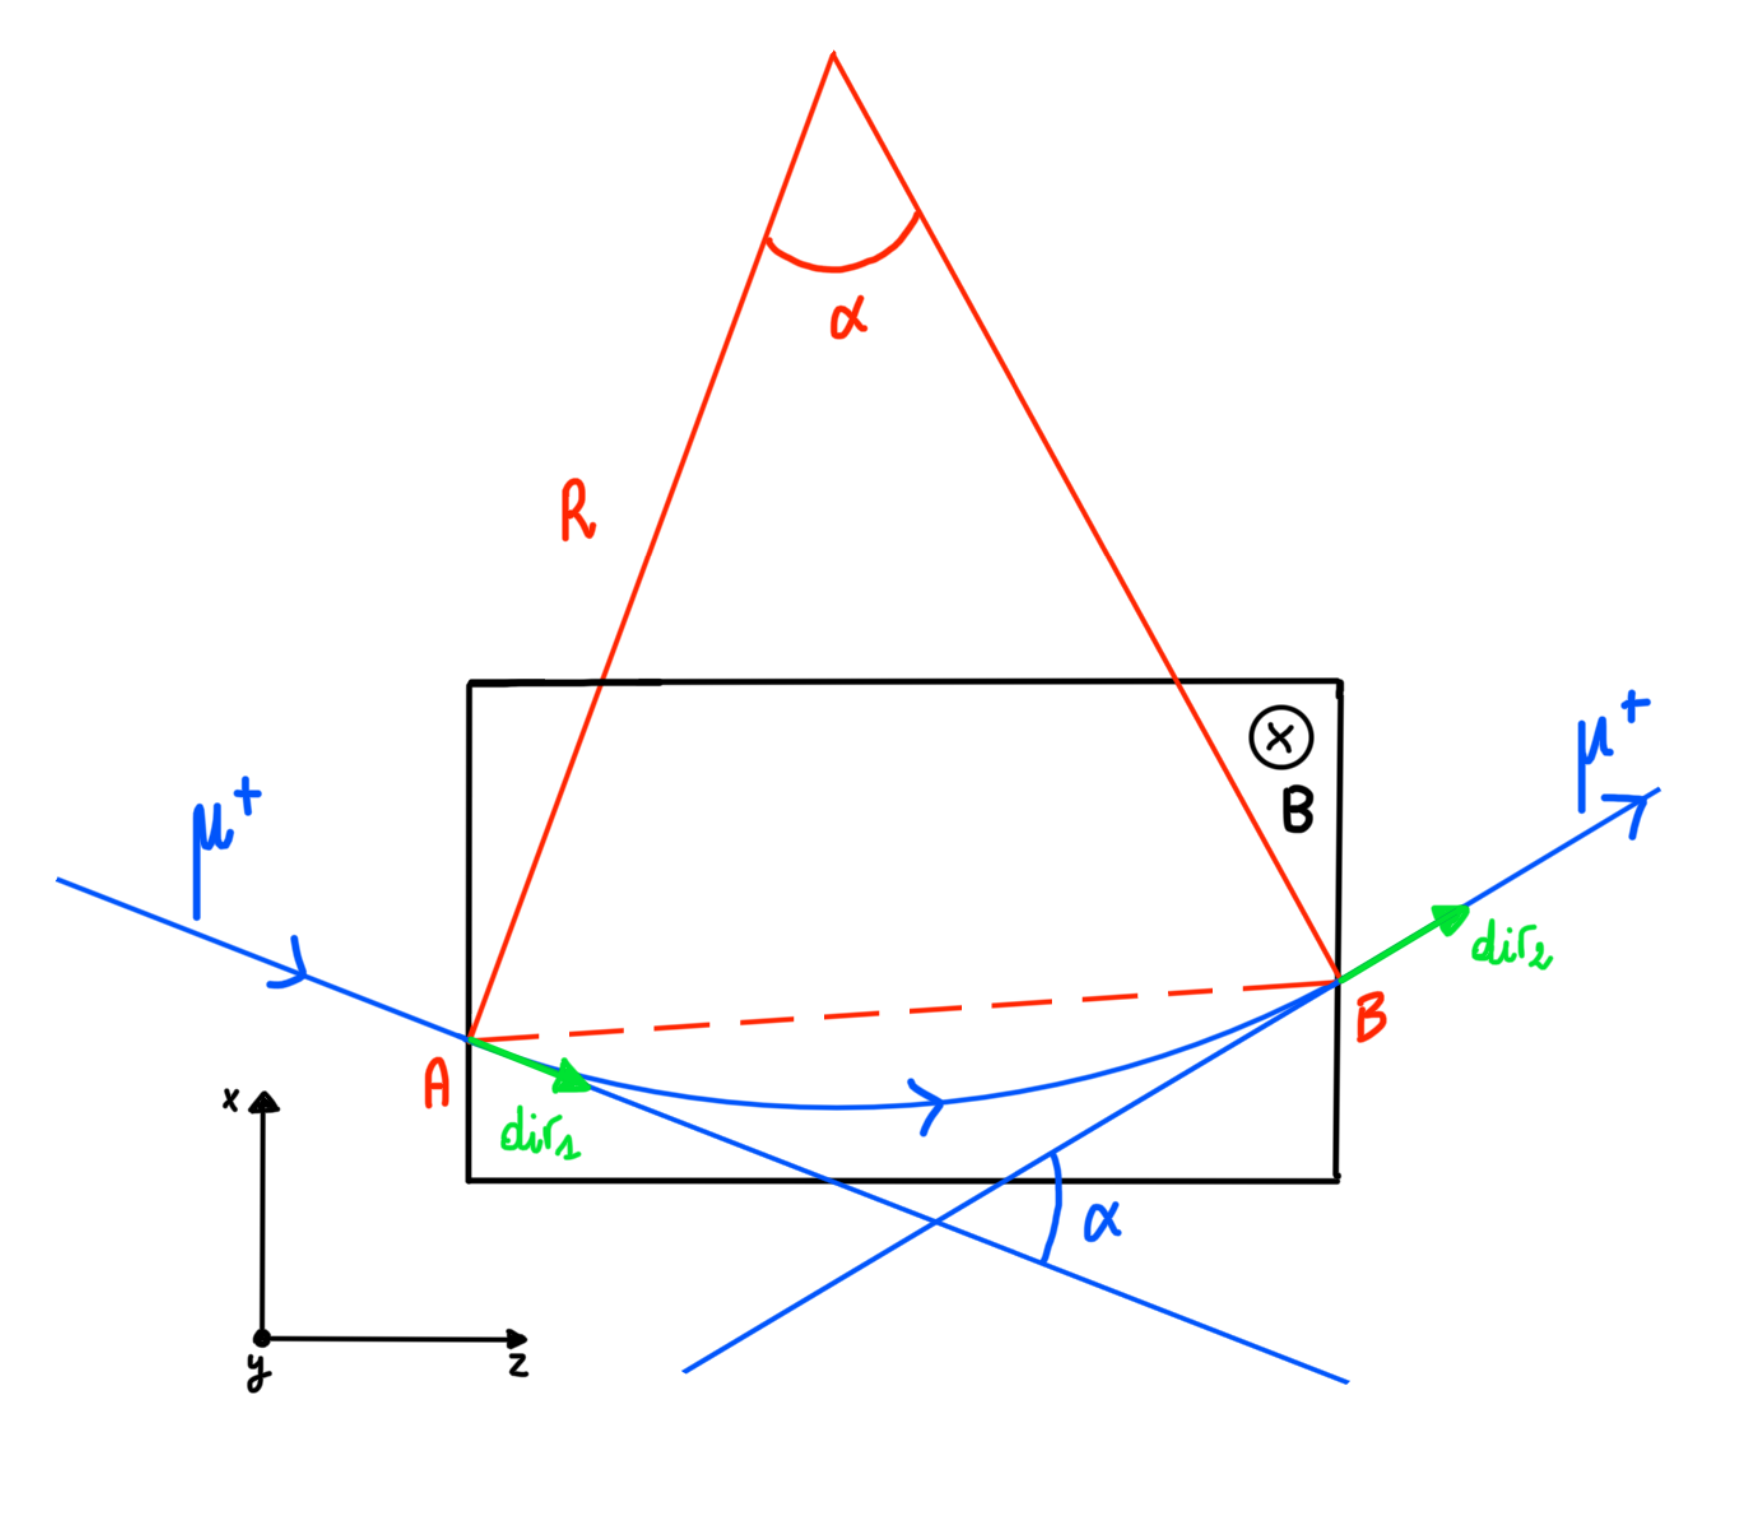

In [ ]:
Image("momenta_rec.png",width=600,height=300)

In [ ]:
def momenta(data_before, data_after):
    x_in = data_before['Sl_x']*Z_mag+data_before['Int_x']
    x_out = data_after['Sl_x']*(Z_mag+L)+data_after['Int_x']
    err_x_in = np.sqrt((Z_mag*data_before['Err_Sl_x'])**2+data_before['Err_Int_x']**2)
    err_x_out = np.sqrt(((Z_mag+L)*data_after['Err_Sl_x'])**2+data_after['Err_Int_x']**2)
    
    y_in = data_before['Sl_y']*Z_mag+data_before['Int_y']
    y_out = data_after['Sl_y']*(Z_mag+L)+data_after['Int_y']
    err_y_in = np.sqrt((Z_mag*data_before['Err_Sl_y'])**2+data_before['Err_Int_y']**2)
    err_y_out = np.sqrt(((Z_mag+L)*data_after['Err_Sl_y'])**2+data_after['Err_Int_y']**2)
    
    #p_xz + errors
    string = np.sqrt((x_out-x_in)**2+(L)**2)
    err_string = np.sqrt(((x_out-x_in)/string)**2*(err_x_in**2+err_x_out**2))
    
    ## inner product -> alpha
    inner_prod = data_before['Sl_x']*data_after['Sl_x'] + 1
    mod_bef = np.sqrt(data_before['Sl_x']**2+1)
    mod_aft = np.sqrt(data_after['Sl_x']**2+1)
    err_inner_prod = np.sqrt((data_before['Err_Sl_x']*data_after['Sl_x'])**2 +
                             (data_before['Sl_x']*data_after['Err_Sl_x'])**2)
    err_mod_bef = (data_before['Err_Sl_x']*data_before['Sl_x'])/mod_bef
    err_mod_aft = (data_after['Err_Sl_x']*data_after['Sl_x'])/mod_aft
    
    alpha = np.arccos(inner_prod/(mod_aft*mod_bef))
    
    dev_arccos=1/np.sqrt(1-(inner_prod/(mod_aft*mod_bef))**2)
    err_alpha=dev_arccos*np.sqrt((err_inner_prod/(mod_aft*mod_bef))**2
                                     +(inner_prod/(mod_aft*mod_bef))**2*((err_mod_bef/mod_bef)**2+(err_mod_aft/mod_aft)**2))
    
    ## alpha -> R
    R=(string/(2*np.sin(alpha/2)))
    err_R = np.sqrt((1/(2*np.sin(alpha/2))*err_string)**2+
                    ((string/4)*(np.cos(alpha/2)/np.sin(alpha/2)**2)*err_alpha)**2)
    
    ## R->P
    P=0.3*B*R
    err_P = 0.3*B*err_R
    
    #p_y + errors
    dist=R*alpha
    t=dist/P
    err_t=np.sqrt((R/P*err_alpha)**2+(alpha/P*err_R)**2+((R*alpha)/P**2*err_P)**2)
    
    P_y=(y_out-y_in)/t
    err_P_y=np.sqrt((1/t*err_y_in)**2+(1/t*err_y_out)**2+(((y_out-y_in)/t**2)*err_t)**2)
    
    #p_tot + errors
    P_tot=np.sqrt(P_y**2+P**2)
    err_tot=np.sqrt(((P/P_tot)*err_P)**2+(P_y/P_tot*err_P_y)**2)
    #print(err_tot/P_tot*100)
    
    return np.column_stack((P_tot,err_tot))

In [ ]:
#plot function
def total_mom(sim1,rec1,sim2,rec2):
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(20,6))
    ax1.set_title('Simulated vs Reconstructed Momentum of the muons')
    ax2.set_title('Simulated vs Reconstructed Momentum of the antimuons')
    
    ax1.hist(rec1,bins=100,alpha = 0.5, lw=3,label="Reconstruction")
    ax1.hist(sim1,bins=100,alpha = 1, lw=3,label="Simulation",histtype='step',color='r')
    
    ax1.set_xlabel("Momentum[GeV]")
    ax1.set_ylabel("Counts")
    ax1.set_yscale("log")
    
    ax2.hist(rec2,bins=100,alpha = 0.5, lw=3,label="Reconstruction")
    ax2.hist(sim2,bins=100,alpha = 1, lw=3,label="Simulation",histtype='step',color='r')
    ax2.set_xlabel("Momentum[GeV]")
    ax2.set_ylabel("Counts")
    ax2.set_yscale("log")
    
    ax1.legend()
    ax2.legend()
    plt.show()

In [ ]:
#muons
fit_pos_mu_n=pd.read_csv("fit_pos_mu_n.csv",index_col=0)
fit_pos_mu_n_after=pd.read_csv("fit_pos_mu_n_after.csv",index_col=0)

mom_n=momenta(fit_pos_mu_n,fit_pos_mu_n_after)

In [ ]:
#antimuons
fit_pos_mu_p=pd.read_csv("fit_pos_mu_p.csv",index_col=0)
fit_pos_mu_p_after=pd.read_csv("fit_pos_mu_p_after.csv",index_col=0)

mom_p=momenta(fit_pos_mu_p,fit_pos_mu_p_after)

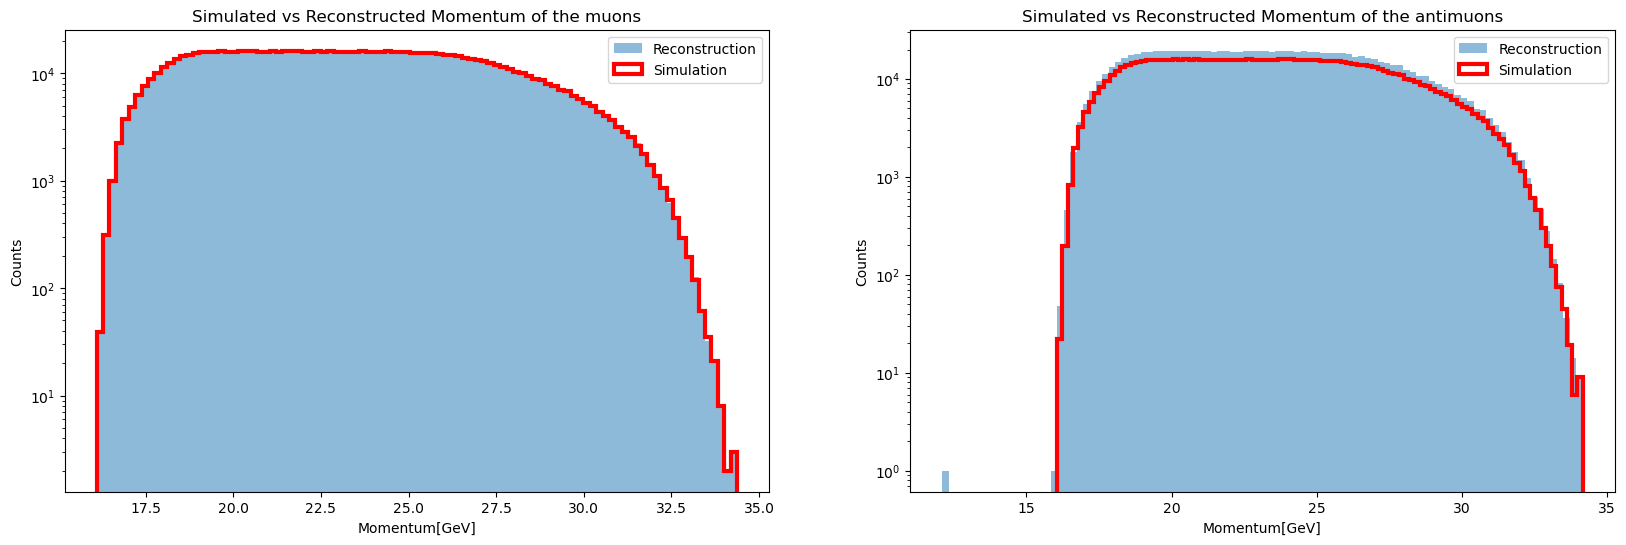

In [ ]:
#that's the results
mom_tot_n=np.sqrt(Px_mu1**2+Py_mu1**2+Pz_mu1**2)
mom_tot_p=np.sqrt(Px_mu2**2+Py_mu2**2+Pz_mu2**2)
total_mom(mom_tot_n,mom_n[:,0],mom_tot_p,mom_p[:,0])

We can remove some outliers just to check the shape of histogram in the interesting range of momentum.

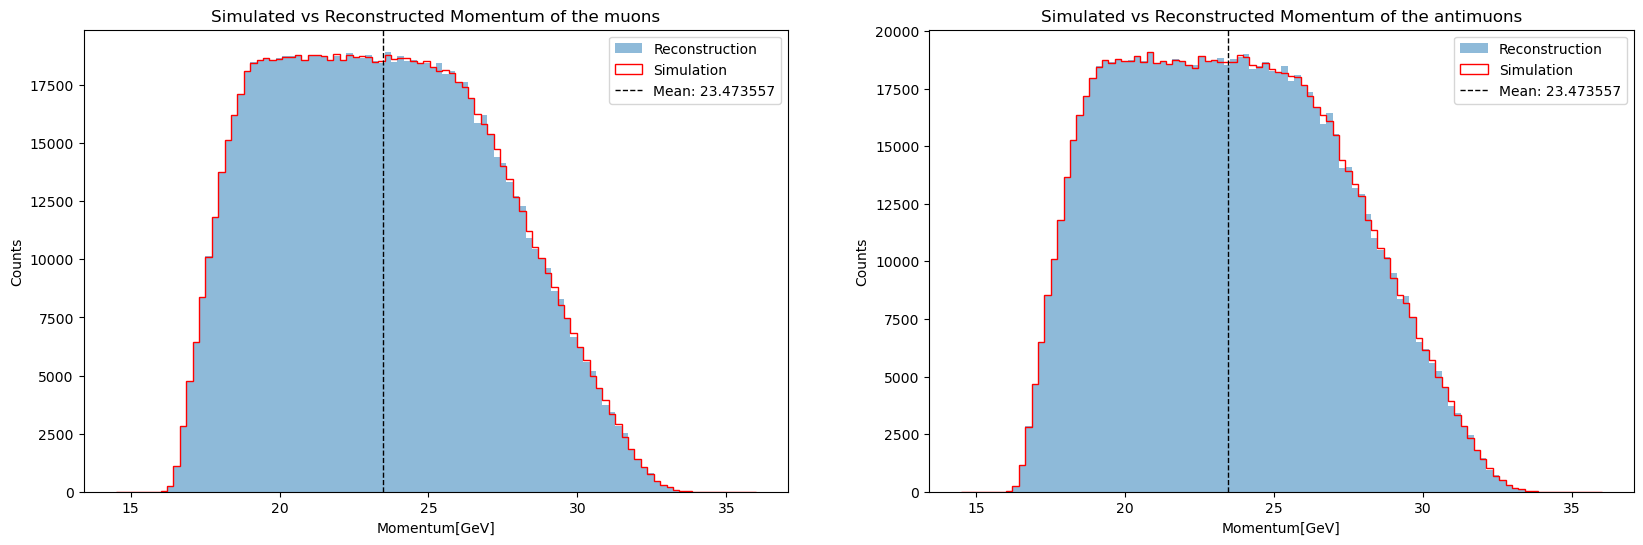

Avarage Recostructed total momentum of muons: 23.473557 GeV
Avarage Recostructed total momentum of antimuons: 23.473557 GeV


In [ ]:
#we have to avoid missfitted values
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,6))

ax1.set_title('Simulated vs Reconstructed Momentum of the muons')
ax2.set_title('Simulated vs Reconstructed Momentum of the antimuons')
ax1.hist(mom_n[:,0],alpha=0.5,bins=100,range=[14.5,36],label="Reconstruction")
ax1.hist(mom_tot_n,alpha=1,bins=100,range=[14.5,36],label="Simulation",histtype='step',color='r')

mean1=mom_n[:,0].mean()
ax1.axvline(mean1, color='k', linestyle='dashed', linewidth=1,label= "Mean: "+str(round(mean1,6)))
ax1.set_xlabel("Momentum[GeV]")
ax1.set_ylabel("Counts")

ax2.hist(mom_p[:,0],alpha=0.5,bins=100,range=[14.5,36],label="Reconstruction")
ax2.hist(mom_tot_p,alpha=1,bins=100,range=[14.5,36],label="Simulation",histtype='step',color='r')

mean2=mom_n[:,0].mean()
ax2.axvline(mean2, color='k', linestyle='dashed', linewidth=1,label= "Mean: "+str(round(mean1,6)))
ax2.set_xlabel("Momentum[GeV]")
ax2.set_ylabel("Counts")

ax1.legend()
ax2.legend()
plt.show()

print("Avarage Recostructed total momentum of muons: "+str(round(mean1,6)),"GeV")
print("Avarage Recostructed total momentum of antimuons: "+str(round(mean2,6)),"GeV")

In [ ]:
miss1=mom_n[mom_n[:,0]>mom_tot_n.max()]
miss2=mom_n[mom_n[:,0]<mom_tot_n.min()]
miss3=mom_n[mom_p[:,0]>mom_tot_p.max()]
miss4=mom_n[mom_p[:,0]<mom_tot_p.min()]

missed=(len(miss1)+len(miss2)+len(miss3)+len(miss4))
print("How many values are wrongly fitted? {}".format(missed))
print("Fitting efficiency: {:.4f}%".format((len(df)-missed)/len(df)*100))

How many values are wrongly fitted? 2
Fitting efficiency: 99.9998%


What about the residuals?

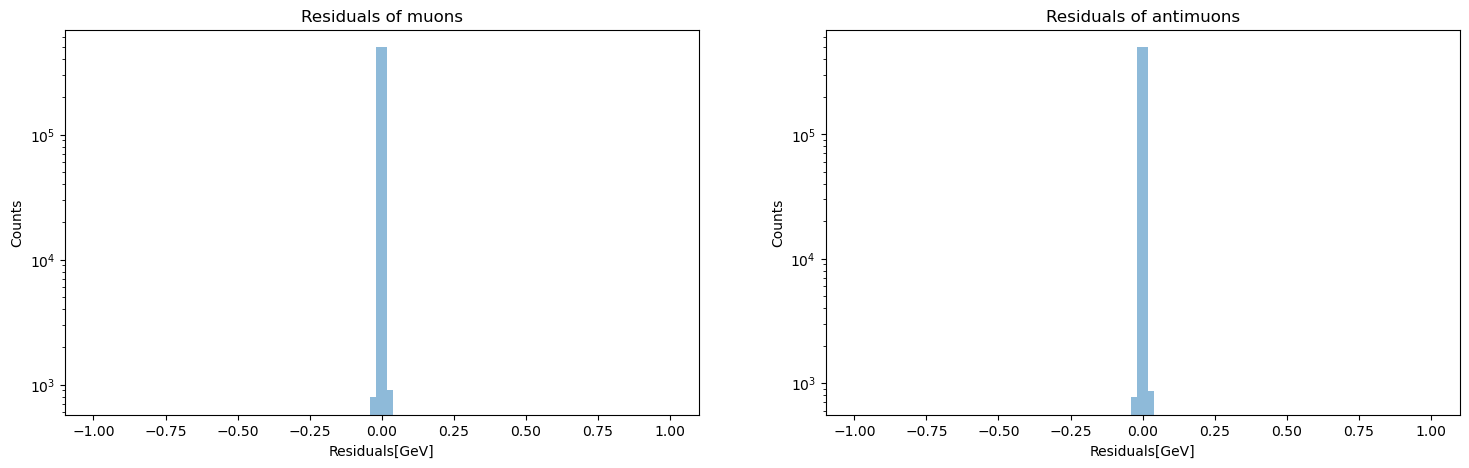

In [ ]:
#residuals
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))

ax1.set_title('Residuals of muons')
ax2.set_title('Residuals of antimuons')
ax1.hist(mom_n[:,0]-mom_tot_n,alpha=0.5,bins=100,range=[-1,1])
ax2.hist(mom_p[:,0]-mom_tot_p,alpha=0.5,bins=100,range=[-1,1])
ax1.set_xlabel("Residuals[GeV]")
ax1.set_ylabel("Counts")
ax2.set_xlabel("Residuals[GeV]")
ax2.set_ylabel("Counts")

ax1.set_yscale("log")
ax2.set_yscale("log")

plt.show()

### Center of mass energy

The center of mass energy of the constructed muons and antimuons is calculated using the following equation:
$$
    s=2m_{\mu}^2 + 2\Big(E_{p}E_{n}-P_{p}P_{n}cos(\theta)\Big)
$$
where $m_{mu}$ is the mass of the muon and $P_{n},P_{p}$ are the tri-momenta of the muons and antimuons, $\theta$ is the angle between the muon and antimuon after scattering and $E_{p},E_{n}$ are the energies of the muons and antimuons. The following equation can be used to calculate them: 

$$E_{n,p}=\sqrt{m_{\mu}^{2}+P_{n,p}^{2}}$$


In [ ]:
### reconstruction using fit results ###
En=np.sqrt(mu_mass**2+mom_n[:,0]**2)
Ep=np.sqrt(mu_mass**2+mom_p[:,0]**2)
    
inner_prod = fit_pos_mu_n['Sl_x']*fit_pos_mu_p['Sl_x'] +fit_pos_mu_n['Sl_y']*fit_pos_mu_p['Sl_y']+ 1
mod_n = np.sqrt(fit_pos_mu_n['Sl_x']**2+fit_pos_mu_n['Sl_y']**2+1)
mod_p = np.sqrt(fit_pos_mu_p['Sl_x']**2+fit_pos_mu_n['Sl_y']**2+1)
cos_theta = (inner_prod/(mod_p*mod_n)) #cos(angle between muons after scattering)
  
S=2*mu_mass**2+2*En*Ep-2*mom_n[:,0]*mom_p[:,0]*cos_theta #(center of mass energy)^2
sqrtS=np.sqrt(S)
    
#sigma
pn =  mom_n[:,0]
pp=   mom_p[:,0]
dpn = mom_n[:,1] 
dpp = mom_p[:,1] 

err_modn = np.sqrt((fit_pos_mu_n['Err_Sl_x']*fit_pos_mu_n['Sl_x'])**2+(fit_pos_mu_n['Err_Sl_y']*fit_pos_mu_n['Sl_y'])**2)/mod_n
err_modp = np.sqrt((fit_pos_mu_p['Err_Sl_x']*fit_pos_mu_p['Sl_x'])**2+(fit_pos_mu_p['Err_Sl_y']*fit_pos_mu_p['Sl_y'])**2)/mod_p
err_inner_prod = np.sqrt((fit_pos_mu_n['Err_Sl_x']*fit_pos_mu_p['Sl_x'])**2+
                         (fit_pos_mu_n['Sl_x']*fit_pos_mu_p['Err_Sl_x'])**2+
                         (fit_pos_mu_n['Err_Sl_y']*fit_pos_mu_p['Sl_y'])**2+
                         (fit_pos_mu_n['Sl_y']*fit_pos_mu_p['Err_Sl_y'])**2)
err_costheta = np.sqrt((1/(mod_p*mod_n)*err_inner_prod)**2 + 
                       (inner_prod/(mod_p*mod_n**2)*err_modn)**2 + 
                       ((inner_prod/(mod_n*mod_p**2)*err_modp)**2))# error of the cos andle between muons and antimuons after scattering

err_s= np.sqrt(((2*Ep/En*pn-2*pp*cos_theta)*dpn)**2 +
               ((2*En/Ep*pp-2*pn*cos_theta)*dpp)**2 + 
               (2*pn*pp*err_costheta)**2)
err_ssq = err_s/(2*sqrtS) #error of the center of mass energy

Center of mass energy of positrons is calculated using the following equation where $m_{e}$ is the mass of a positron and $E_{e}$ is the energy of positron (we are working in the rest frame of the electrons): 
$$ p_{e^+}=\Big(E_e,\sqrt{E_e^2-m_e^2},0,0\Big) $$
$$ p_{e^-}=\Big(m_e,0,0,0\Big)$$ 
$$ s_{e^+}=(p_{e^+}+p_{e^-})^2=m_e^2+E_e^2+2\cdot m_e\cdot E_e -E_e^2+m_e^2=2(E_{e}+m_e)m_{e} $$

Then the center of mass energy of muons and antimuons is also calculated with the simulated data from the equation described before to observe the two distributions.  

In [ ]:
### simulation part ###

#center of mass energy calculation using positrons
P_e=np.sqrt(px_e**2+py_e**2+pz_e**2)
m_e=0.511/1000
E_e=np.sqrt(P_e**2+m_e**2)
S_e=2*(E_e+m_e)*m_e 

#center of mass energy calculation using muons
inner_prod_sim=Px_mu1*Px_mu2+Py_mu1*Py_mu2+Pz_mu1*Pz_mu2
cos_theta_sim=inner_prod_sim/(mom_tot_n*mom_tot_p)

En_sim=np.sqrt(mu_mass**2+mom_tot_n**2)
Ep_sim=np.sqrt(mu_mass**2+mom_tot_p**2)

S_sim=2*mu_mass**2+2*(En_sim*Ep_sim-mom_tot_n*mom_tot_p*cos_theta_sim)
sqrtS_sim=np.sqrt(S_sim)

In [ ]:
miss1=S[S>S_sim.max()]
miss2=S[S<S_sim.min()]

missed=(len(miss1)+len(miss2))
print("How many values are wrongly fitted? {}".format(missed))
print("Fitting efficiency: {:.4f}%".format((len(df)-missed)/len(df)*100))

How many values are wrongly fitted? 31
Fitting efficiency: 99.9969%


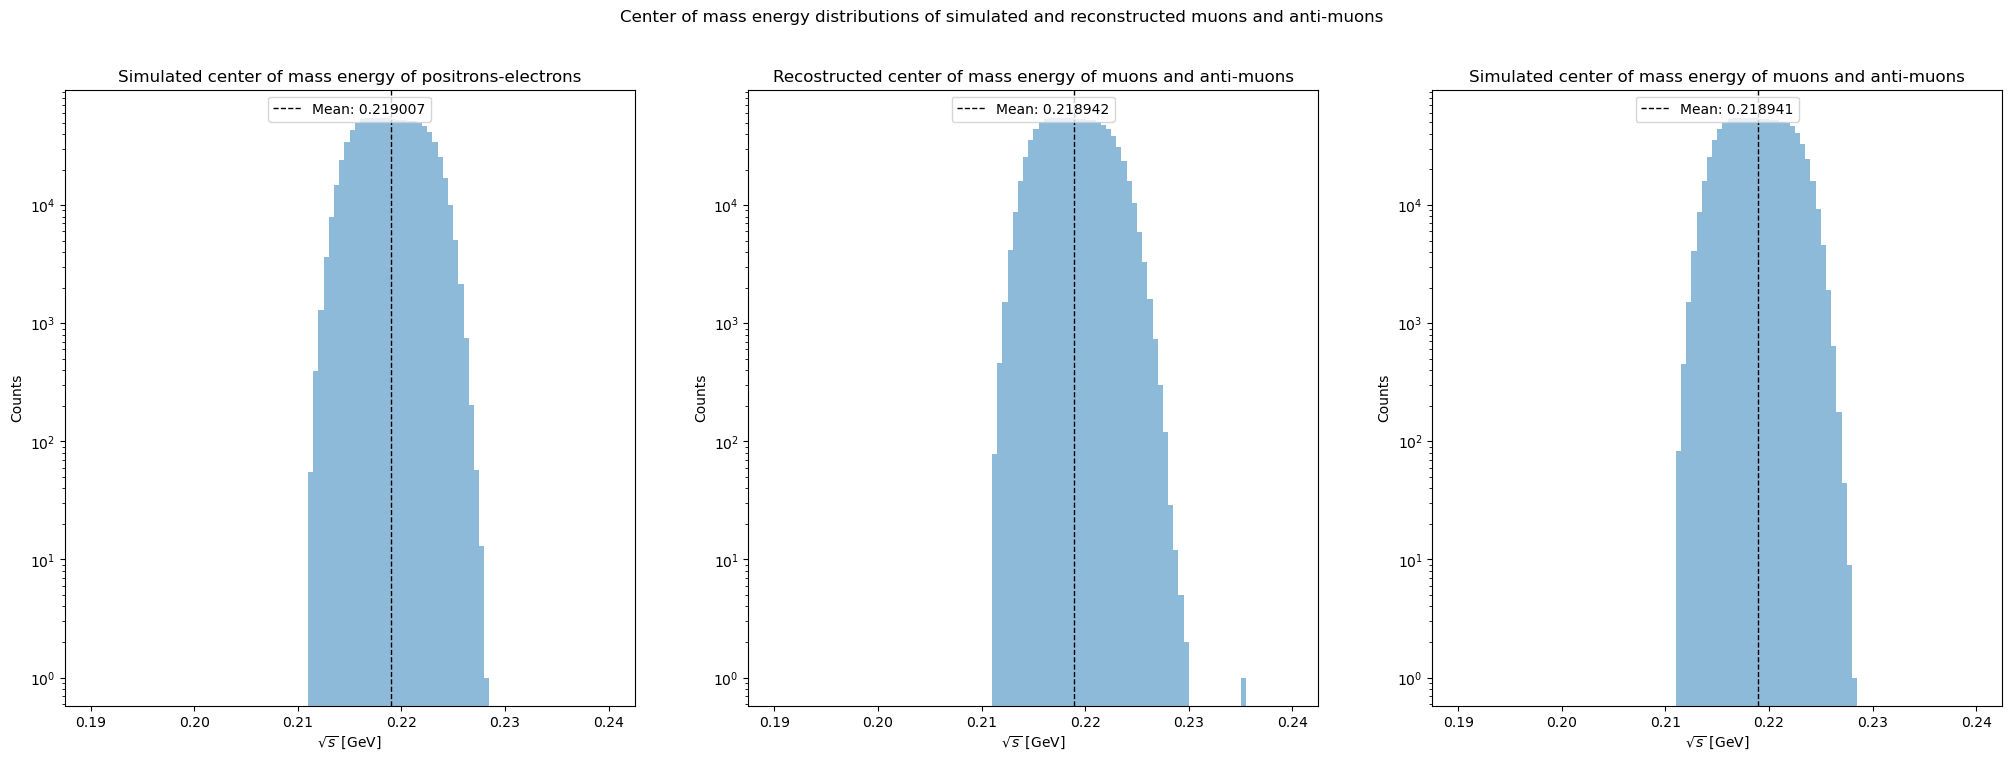

Avarage Recostructed center of mass energy of muons and anti-muons: 0.218942 GeV


In [ ]:
fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(25,8))
fig.suptitle('Center of mass energy distributions of simulated and reconstructed muons and anti-muons')

ax1.hist(np.sqrt(S_e),alpha=0.5, range =[0.19,0.24],bins=100)
mystring1 = "Mean: "+str(round(np.sqrt(S_e).mean(),6))
ax1.axvline(np.sqrt(S_e).mean(), color='k', linestyle='dashed', linewidth=1,label=mystring1)
ax1.legend(loc = 'upper center')
ax1.set_xlabel("$\sqrt{s}$ [GeV]")
ax1.set_ylabel("Counts")
ax1.set_yscale("log")
ax1.set_title('Simulated center of mass energy of positrons-electrons')

ax2.hist(sqrtS,bins=100,alpha = 0.5, lw=3,range=[0.19,0.24])
mystring = "Mean: "+str(round(sqrtS.mean(),6))
ax2.axvline(sqrtS.mean(), color='k', linestyle='dashed', linewidth=1,label= mystring)
ax2.legend(loc = 'upper center')
ax2.set_xlabel("$\sqrt{s}$ [GeV]")
ax2.set_ylabel("Counts")
ax2.set_yscale("log")
ax2.set_title('Recostructed center of mass energy of muons and anti-muons')

ax3.hist(sqrtS_sim,bins=100, range =[0.19,0.24],alpha = 0.5, lw=3)
mystring = "Mean: "+str(round(sqrtS_sim.mean(),6))
ax3.axvline(sqrtS_sim.mean(), color='k', linestyle='dashed',linewidth=1,label= mystring)
ax3.legend(loc = 'upper center')
ax3.set_xlabel("$\sqrt{s}$ [GeV]")
ax3.set_ylabel("Counts")
ax3.set_yscale("log")
ax3.set_title('Simulated center of mass energy of muons and anti-muons')
plt.show()

print("Avarage Recostructed center of mass energy of muons and anti-muons: "+str(round(sqrtS.mean(),6)),"GeV")

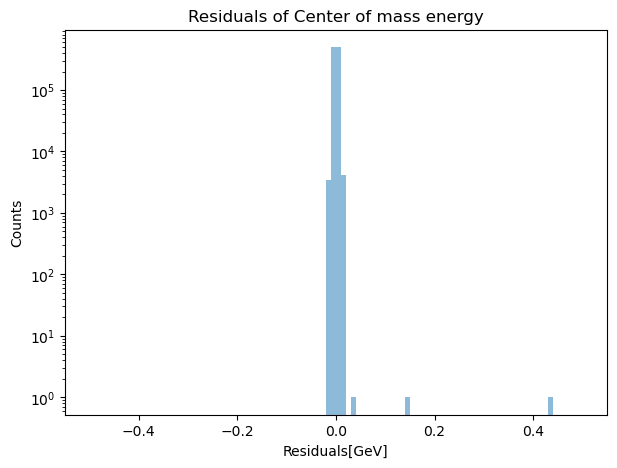

In [ ]:
#residuals
fig,ax=plt.subplots(1,1,figsize=(7,5))
ax.set_title('Residuals of Center of mass energy')
ax.hist(sqrtS-sqrtS_sim,alpha=0.5,bins=100,range=[-.5,.5])
ax.set_xlabel("Residuals[GeV]")
ax.set_ylabel("Counts")
ax.set_yscale("log")
plt.show()

## Resolution

### Momentum

In [ ]:
def resolution_p(muon,antimuon):
    
    #muon and antimuon have to be filled with [mom_tot, sigma_mom]
    
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,6))
    
    ax1.set_title('Momentum resolution of the muons')
    ax2.set_title('Momentum resolution of the antimuons')
    
    ax1.hist(muon[:,1]/muon[:,0],bins=100,alpha = 0.5, lw=3,color='r')
    ax2.hist(antimuon[:,1]/antimuon[:,0],bins=100,alpha = 0.5, lw=3,color='r')
    
    mean1=(muon[:,1]/muon[:,0]).mean()
    mean2=(antimuon[:,1]/antimuon[:,0]).mean()
    ax1.set_xlabel("$\sigma_p/p$")
    ax1.set_ylabel("Counts")
    ax1.axvline((muon[:,1]/muon[:,0]).mean(), color='k', linestyle='dashed', linewidth=1,label= str(round(mean1,6)))
    
    ax2.set_xlabel("$\sigma_p/p$")
    ax2.set_ylabel("Counts")
    ax2.axvline((antimuon[:,1]/antimuon[:,0]).mean(), color='k', linestyle='dashed', linewidth=1,label= str(round(mean1,6)))
    
    
    print("Avarage Recostructed Muon relative resolution: "+str(round(mean1,6)))
    print("Avarage Recostructed antiMuon relative resolution: "+str(round(mean2,6)))
    
    ax1.legend()
    ax2.legend()
    
    plt.show()

Avarage Recostructed Muon relative resolution: 0.000188
Avarage Recostructed antiMuon relative resolution: 0.000188


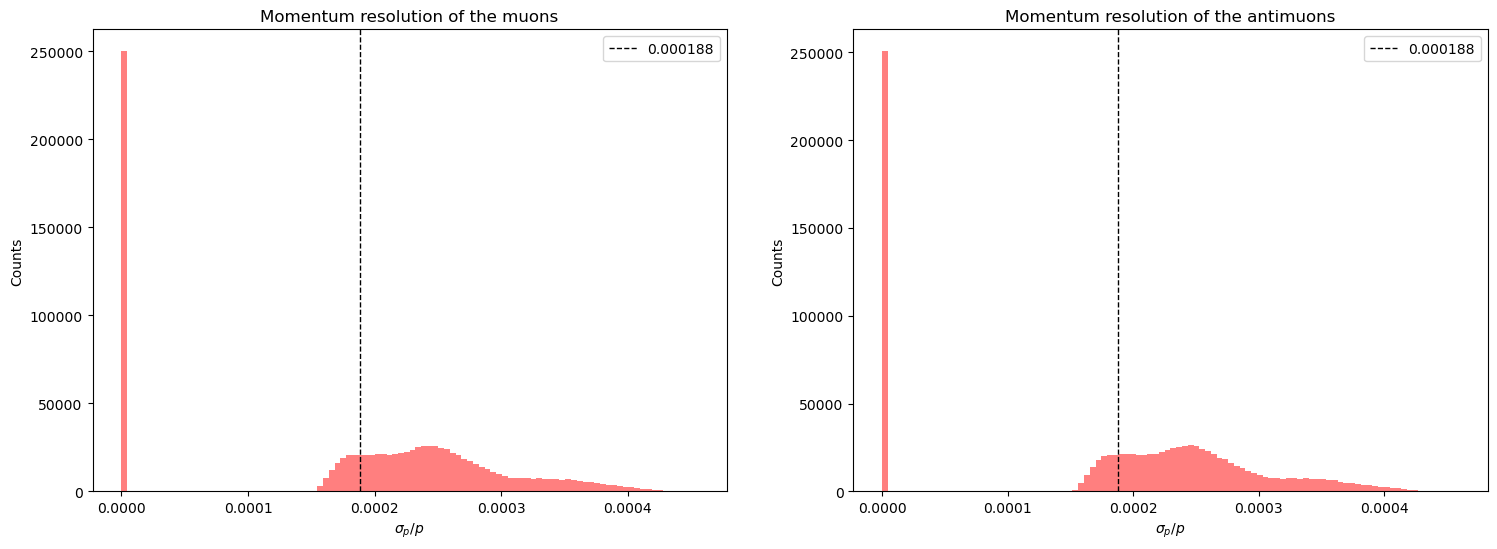

In [ ]:
resolution_p(mom_n,mom_p)

Let's see how the relative resolution behave w.r.t. the momentum.

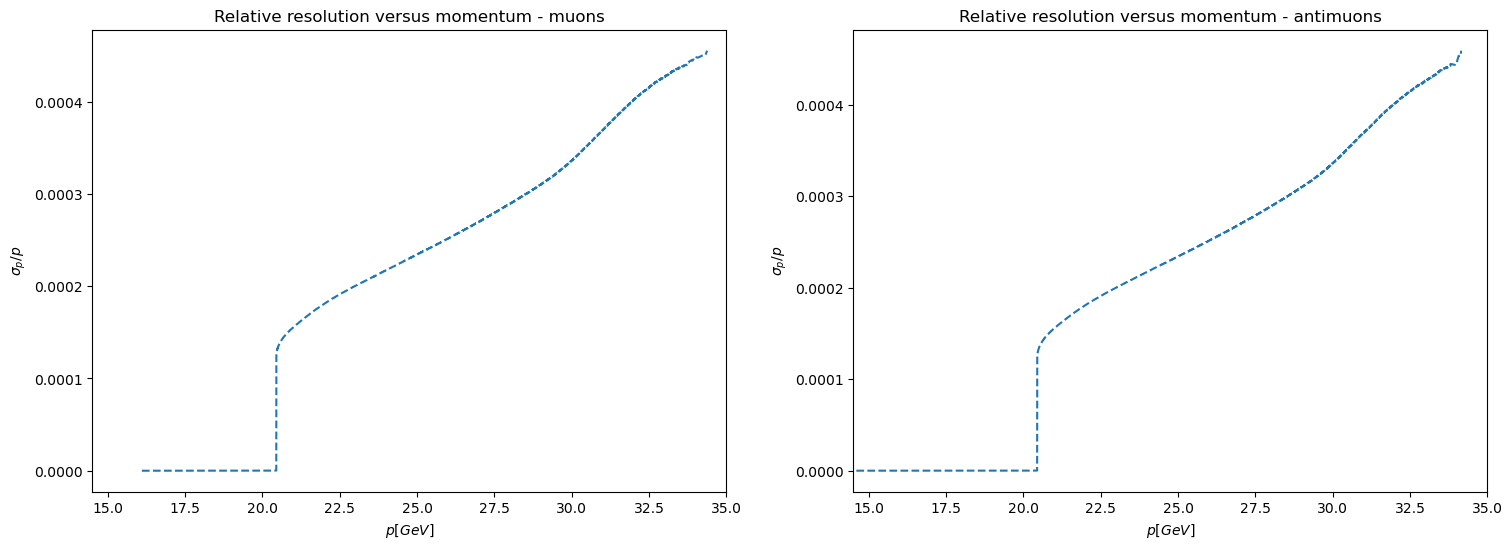

In [ ]:
sorted_m_n=mom_n.copy()
sorted_m_n.sort(axis=0)

sorted_m_p=mom_p.copy()
sorted_m_p.sort(axis=0)

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(18,6))

ax1.set_title('Relative resolution versus momentum - muons')
ax2.set_title('Relative resolution versus momentum - antimuons')

ax1.plot(sorted_m_n[:,0],sorted_m_n[:,1]/sorted_m_n[:,0],linestyle="dashed")
ax1.set_ylabel("$\sigma_p/p$")
ax1.set_xlabel("$p[GeV]$")
ax1.set_xlim(14.5,35) #removing outliers

ax2.plot(sorted_m_p[:,0],sorted_m_p[:,1]/sorted_m_p[:,0],linestyle="dashed")
ax2.set_ylabel("$\sigma_p/p$")
ax2.set_xlabel("$p [GeV]$")
ax2.set_xlim(14.5,35) #removing outliers
plt.show()

### Center of mass energy

In [ ]:
def resolution_s(sqrtS,err_ssq):
    
    fig, (ax1)=plt.subplots(1,1,figsize=(18,6))  
    ax1.set_title('Center of mass energy resolution of the muons')   
    ax1.hist(err_ssq/sqrtS,bins=100,alpha = 0.5, lw=3,color='r')  
    mean1=(err_ssq/sqrtS).mean()
    ax1.set_xlabel("$\sigma_{\sqrt{s}}/\sqrt{s}$")
    ax1.set_ylabel("Counts")
    ax1.axvline(mean1, color='k', linestyle='dashed', linewidth=1,label= "Mean: "+str(round(mean1,6)))  
    print("Center of mass energy resolution mean: {}".format(round(mean1,6)))  
    ax1.legend()  
    plt.show()

Center of mass energy resolution mean: 0.000206


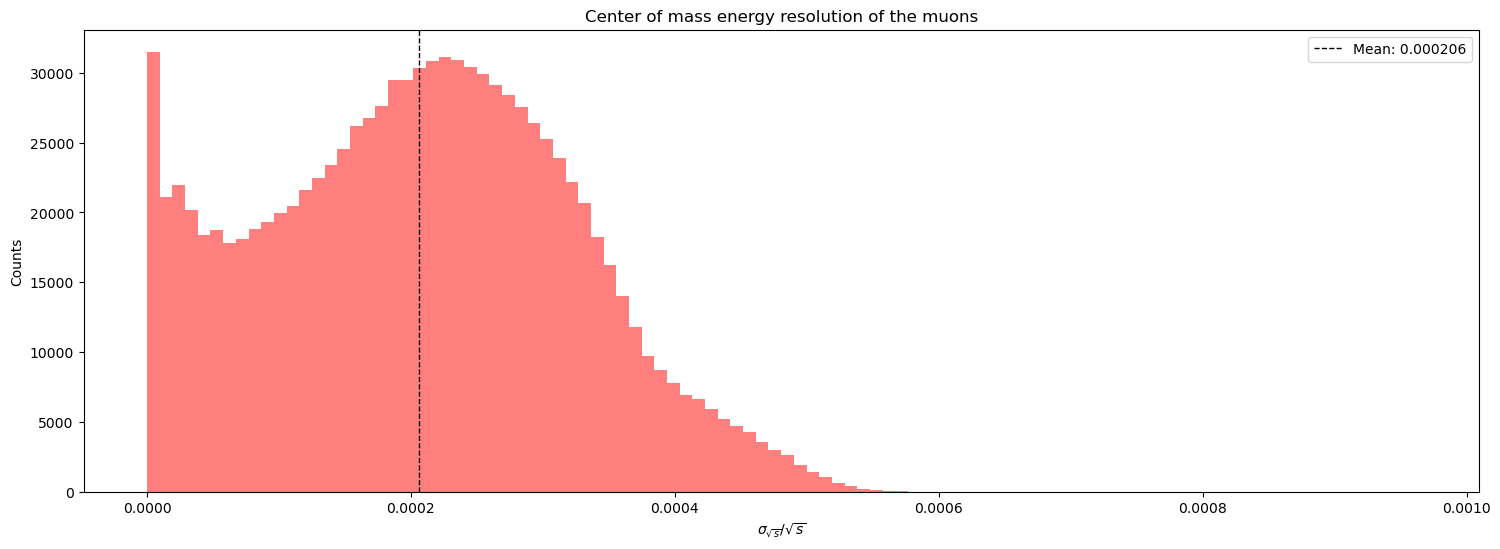

In [ ]:
resolution_s(sqrtS,err_ssq)

Let's see how the relative resolution behave w.r.t. the center of mass energy.

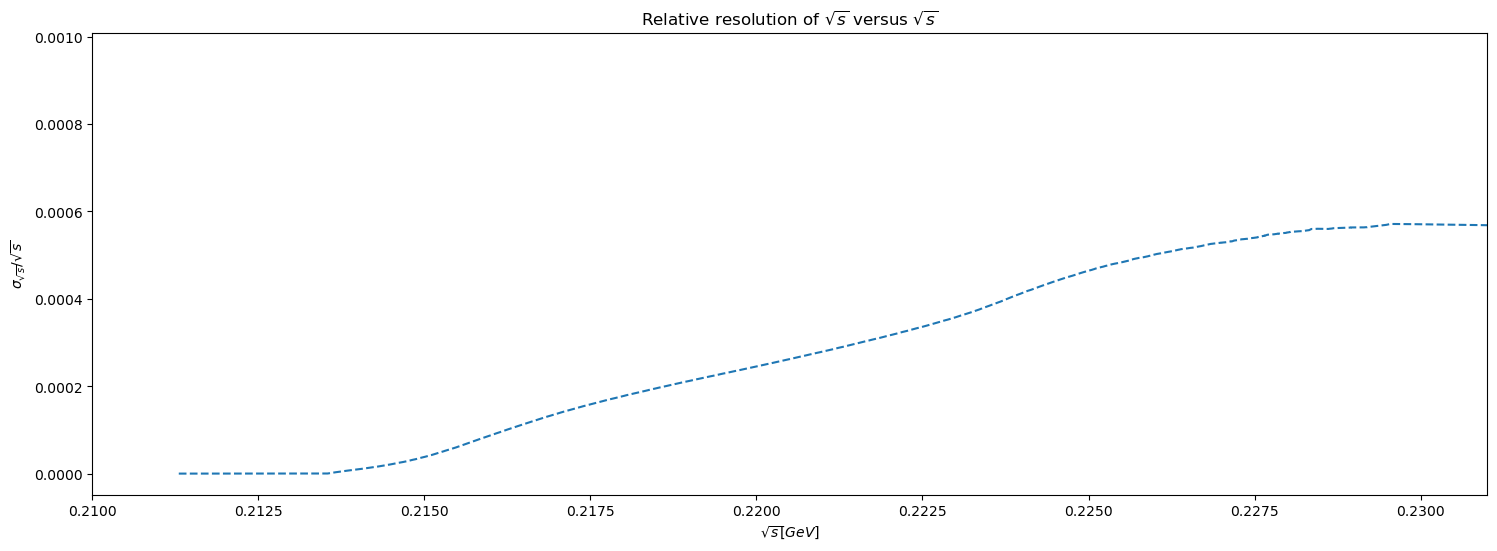

In [ ]:
sorted_s=np.sort(sqrtS)
sorted_sig=np.sort(err_ssq)

fig, ax1=plt.subplots(1,1,figsize=(18,6))

ax1.set_title("Relative resolution of $\sqrt{s}$ versus $\sqrt{s}$")

ax1.plot(sorted_s,sorted_sig/sorted_s,linestyle="dashed")

ax1.set_xlim(0.210, 0.231)  # we focus in the most interesting part, 
                            # avoiding outliears due to issues in event generations and/or in the tracking part
    
ax1.set_ylabel("$\sigma_{\sqrt{s}}/\sqrt{s}$")
ax1.set_xlabel("$\sqrt{s} [GeV]$")
plt.show()

## Conclusion

In conclusion we obtained good performances in terms of obtained resolutions obtained, as the order of magnitude for momenta and energy is $10^{-4}$. The tracking code worked well since the efficiency is around 99.99% for both momentum and energy reconstruction, with few outliers.

Through the residuals, calculated by comparison with between simulation and tracking, the efficiency of the methods used is confirmed.

## Backup

### $\Delta E_{\mu}$

In [ ]:
E_muon = np.sort(np.sqrt((mu_mass)**2+mom_n[:,0]**2))
maxEn=np.mean(E_muon[E_muon.shape[0]-50:])
minEn=np.mean(E_muon[:50])
print('Energy max muon:', maxEn)
print('Energy min muon:',minEn)

E_antimuon = np.sort(np.sqrt(mu_mass**2+mom_p[:,0]**2))
maxEp=np.mean(E_muon[E_antimuon.shape[0]-50:])
minEp=np.mean(E_antimuon[:50])
print('Energy max antimuon:', maxEp)
print('Energy min antimuon:', minEp)

Energy max muon: 33.76466951906561
Energy min muon: 16.247207651635478
Energy max antimuon: 33.76466951906561
Energy min antimuon: 16.15595839491626


In [ ]:
deltaN=np.mean(E_muon[E_muon.shape[0]-1000:])-np.mean(E_muon[:1000])
deltaP=np.mean(E_antimuon[E_antimuon.shape[0]-1000:])-np.mean(E_antimuon[:1000])

print("Energy diff muons:",deltaN)
print("Energy diff antimuons:",deltaP)

Energy diff muons: 16.46479376561074
Energy diff antimuons: 16.46674243104631


In [ ]:
mmu=105.6583
me=0.511
theo_diff=218
s=219**2

delta=np.sqrt(s)/(2*me)*np.sqrt(s/4-mmu**2)
delta

6160.755805238976

### $\theta_{max}$

In [ ]:
s = 218**2
th_max = 4 * me * np.sqrt(s/4 - mmu**2) / s
print("Maximum angle at ", np.sqrt(s), "MeV: ", th_max, "rad")

Maximum angle at  218.0 MeV:  0.0011519283754758188 rad


In [ ]:
#reconstructed max angle
thet=np.sort(np.arccos(cos_theta)/2)[::-1]
thet[0:100000].mean()

0.001428198731537249